# 1.Import

In [104]:
import random
import copy

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score




In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
hiv_link = "/content/drive/MyDrive/ProjectHIV/IAAR72DT/IAAR72FL.DTA"
men_o_link = "/content/drive/MyDrive/ProjectHIV/IAMR74DT/IAMR74FL.DTA"
men_link = "/content/drive/MyDrive/ProjectHIV/IAMR74DT/IAMR74FL.csv"
map_link = "/content/drive/MyDrive/ProjectHIV/IAMR74DT/mapping.csv"

In [12]:
def read_man_hiv(personlink, hivlink):
    man = pd.read_csv(personlink)
    hiv = pd.read_stata(hiv_link)
    hiv['mv001'] = hiv['hivclust']
    hiv['mv002'] = hiv['hivnumb']
    hiv['mv003'] = hiv['hivline']
    print('HIV df shape:', hiv.shape)
    print('Man df shape:', man.shape)
    dfinal = pd.merge(hiv, man, on=['mv001', 'mv002', 'mv003'], how = 'inner')
    print('Final df shape:', dfinal.shape)
    df = dfinal.reset_index(drop=True)
    return df

In [13]:
df0 = read_man_hiv(men_link, hiv_link)

HIV df shape: (230213, 10)
Man df shape: (112122, 747)
Final df shape: (107297, 754)


In [14]:
df_map = pd.read_csv(map_link)

In [16]:
df_map[df_map['ori'] == 'mv770']

ori                                            conv
396  mv770  Sought advice/treatment for last STI infection

# 2.1 EDA HIV

In [ ]:
hiv = pd.read_stata(hiv_link)

hiv.rename(columns={
    "hivclust": "Cluster",
    "hivnumb": "Household",
    "hivline": "Line",
    "hiv01": "Bar code",
    "hiv02": "Lab number",
    "hiv03": "Blood test result",
    "hiv05": "Sample weight"
}, inplace=True)

hiv.head()

Cluster  Household  Line Bar code  Lab number Blood test result  \
0    10001         17     2   4I4K2C      147724      hiv negative   
1    10001         17     1   9D5Z3T      147723      hiv negative   
2    10001         20     1   7V6S3D      147718      hiv negative   
3    10001         20     2   6U2T3Y      147717      hiv negative   
4    10001         29     2   1H2T6J      147720      hiv negative   

   Sample weight  
0        2089100  
1        2206142  
2        2089100  
3        2206142  
4        2089100

In [ ]:
hiv.describe()

Cluster      Household           Line     Lab number  \
count  230213.000000  230213.000000  230213.000000  230213.000000   
mean   201193.228197      50.348829       2.874673  162374.884146   
std    101272.750672      28.582832       1.997775   90372.902956   
min     10001.000000       1.000000       1.000000    5001.000000   
25%    120670.000000      26.000000       2.000000   80733.000000   
50%    191996.000000      51.000000       2.000000  168148.000000   
75%    291640.000000      75.000000       4.000000  240704.000000   
max    360482.000000      99.000000      39.000000  314303.000000   

       Sample weight  
count   2.302130e+05  
mean    9.781246e+05  
std     7.233697e+05  
min     0.000000e+00  
25%     5.722100e+05  
50%     8.518000e+05  
75%     1.221748e+06  
max     2.275818e+07

In [ ]:
hiv['Blood test result'].value_counts()

Blood test result
hiv negative     229711
hiv  positive       499
indeterminate         3
Name: count, dtype: int64

In [ ]:
hiv = hiv[hiv['Blood test result'] != 'indeterminate']
hiv['Blood test result'] = np.where(hiv['Blood test result'] == 'hiv negative', 0, 1)
hiv['Blood test result'].value_counts()

Blood test result
0    229711
1       499
Name: count, dtype: int64

# 2.2 Man

## 2.2.1 Raw Preprocessing

In [27]:
df = df0.copy(deep=True)
df.head()

hivclust  hivnumb  hivline   hiv01   hiv02         hiv03    hiv05  mv001  \
0     10001       17        1  9D5Z3T  147723  hiv negative  2206142  10001   
1     10001       20        2  6U2T3Y  147717  hiv negative  2206142  10001   
2     10001       30        1  4H7E7D  147710  hiv negative  2206142  10001   
3     10001       30        3  6S2T1U  147711  hiv negative  2206142  10001   
4     10001       43        2  5S6G3M  147715  hiv negative  2206142  10001   

   mv002  mv003  ...              sm213   sm190s   sm190u    sm191u  sm190us  \
0     17      1  ...  Currently married  Poorest  Poorest -106084.0  Poorest   
1     20      2  ...      Never married   Richer   Middle   29005.0   Middle   
2     30      1  ...  Currently married   Middle   Poorer   -4964.0   Poorer   
3     30      3  ...      Never married   Middle   Poorer   -4964.0   Poorer   
4     43      2  ...      Never married   Richer   Richer   47001.0   Richer   

   sm190r  sm191r  sm190rs                       smphase  sm221  
0     NaN     NaN      NaN  Phase 1: 2014-15 school year    NaN  
1     NaN     NaN      NaN  Phase 1: 2014-15 school year    NaN  
2     NaN     NaN      NaN  Phase 1: 2014-15 school year    NaN  
3     NaN     NaN      NaN  Phase 1: 2014-15 school year    NaN  
4     NaN     NaN      NaN  Phase 1: 2014-15 school year    NaN  

[5 rows x 754 columns]

In [28]:
df.drop(columns='Unnamed: 0', inplace=True)
df = df[df['hiv03'] != 'indeterminate']
df['hiv03'] = np.where(df['hiv03'] == 'hiv negative', 0, 1)
df['hiv03'].value_counts()

hiv03
0    107058
1       236
Name: count, dtype: int64

In [29]:
df.describe()

hivclust        hivnumb        hivline          hiv02  \
count  107294.000000  107294.000000  107294.000000  107294.000000   
mean   201079.624238      50.353077       2.606092  161810.618059   
std    100653.940582      28.569589       2.064446   90344.280122   
min     10001.000000       1.000000       1.000000    5002.000000   
25%    120636.000000      26.000000       1.000000   80314.750000   
50%    191978.000000      51.000000       2.000000  168384.000000   
75%    291519.000000      75.000000       3.000000  240015.500000   
max    360482.000000      99.000000      37.000000  314303.000000   

               hiv03         hiv05          mv001          mv002  \
count  107294.000000  1.072940e+05  107294.000000  107294.000000   
mean        0.002200  1.033481e+06  201079.624238      50.353077   
std         0.046848  7.598878e+05  100653.940582      28.569589   
min         0.000000  1.345800e+04   10001.000000       1.000000   
25%         0.000000  6.009190e+05  120636.000000      26.000000   
50%         0.000000  8.821950e+05  191978.000000      51.000000   
75%         0.000000  1.271998e+06  291519.000000      75.000000   
max         1.000000  2.275818e+07  360482.000000      99.000000   

               mv003          mv004  ...  smb16d  smb22h  smb22m  smb23d  \
count  107294.000000  107294.000000  ...     0.0     0.0     0.0     0.0   
mean        2.606092     934.602149  ...     NaN     NaN     NaN     NaN   
std         2.064446    1137.780602  ...     NaN     NaN     NaN     NaN   
min         1.000000       1.000000  ...     NaN     NaN     NaN     NaN   
25%         1.000000     267.000000  ...     NaN     NaN     NaN     NaN   
50%         2.000000     592.000000  ...     NaN     NaN     NaN     NaN   
75%         3.000000    1080.000000  ...     NaN     NaN     NaN     NaN   
max        37.000000    6300.000000  ...     NaN     NaN     NaN     NaN   

       smb26h  smb26m  smb27d  smb51         sm191u         sm191r  
count     0.0     0.0     0.0    0.0   33435.000000   73859.000000  
mean      NaN     NaN     NaN    NaN    3911.051443   16699.756739  
std       NaN     NaN     NaN    NaN   96539.224196   99996.402058  
min       NaN     NaN     NaN    NaN -364284.000000 -196393.000000  
25%       NaN     NaN     NaN    NaN  -55667.000000  -61876.500000  
50%       NaN     NaN     NaN    NaN   16644.000000    7401.000000  
75%       NaN     NaN     NaN    NaN   76349.000000   85766.000000  
max       NaN     NaN     NaN    NaN  213969.000000  361582.000000  

[8 rows x 280 columns]

In [30]:
# Drop highly missing features
missing_ratio = df.isnull().mean().sort_values(ascending=False)
high_missing = missing_ratio[missing_ratio > 0.7]
print("Columns with >70% missing:\n", high_missing)
df = df.drop(columns=high_missing.index)


Columns with >70% missing:
 smb51     1.000000
mv026     1.000000
mv028     1.000000
smb13     1.000000
mv027     1.000000
            ...   
mv803     0.776371
mv527     0.761934
mv714a    0.730824
mv853a    0.727841
sm320     0.727049
Length: 308, dtype: float64


In [31]:
n_unique = df.nunique()
constant_columns = n_unique[n_unique <= 1]
print("Column with 1 value:\n", len(constant_columns))
df = df.drop(columns=constant_columns.index)


Column with 1 value:
 37


In [32]:
n_unique = df.nunique()
constant_columns = n_unique[n_unique >= 100]
print("Column with > 100 value:\n", len(constant_columns))
df = df.drop(columns=constant_columns.index)


Column with > 100 value:
 18


In [33]:
df.shape

(107294, 390)

In [35]:
# Drop useless features for prediction
columns_to_drop = [
    # Identification Variables
    'mcaseid', 'mv000', 'mv001', 'mv002', 'mv003', 'mv004',
    'mv021', 'mv022', 'mv023', 'mv024', 'mv101',
    'mv028', 'mv030', 'smsdistri', 'smslumc', 'smslumo', 'smbsel',

    # Survey Process
    'mv006', 'mv007', 'mv008',
    'mv015', 'mv016',
    'mv801', 'mv802', 'mv803', 'smlangi', 'smlangq',

    # Overlapped features
    'mv770',  'mv750', 'mv751',

]

df = df.drop(columns=columns_to_drop, errors='ignore')
df.shape

(107294, 378)

## 2.2.2 EDA

### Socio-demographic & Living Conditions

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Phân bố tuổi người tham gia')

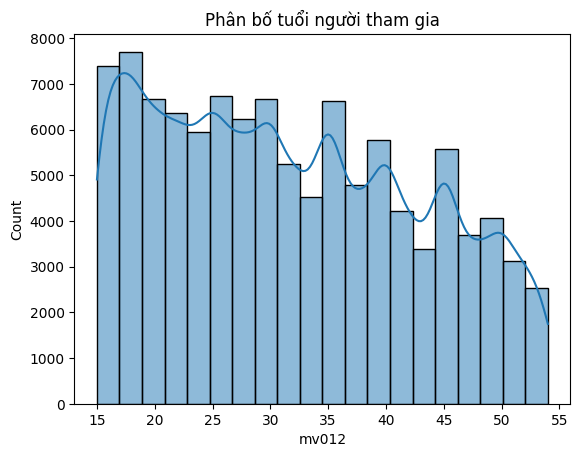

In [ ]:
sns.histplot(df['mv012'], bins=20, kde=True)
plt.title('Phân bố tuổi người tham gia')


Text(0.5, 1.0, 'Phân bố nhóm tuổi 5 năm')

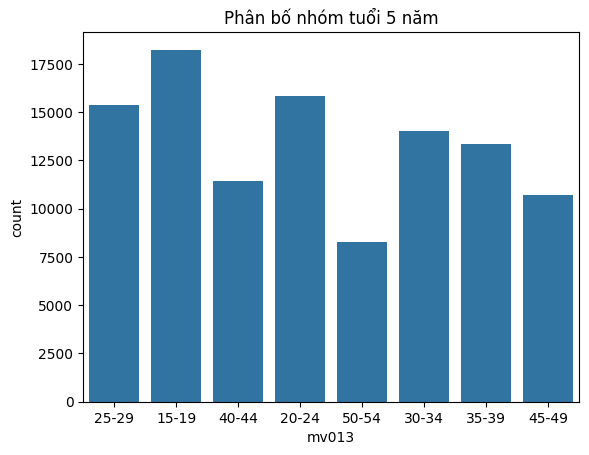

In [ ]:
sns.countplot(data=df, x='mv013')
plt.title('Phân bố nhóm tuổi 5 năm')


Text(0.5, 1.0, 'Trình độ học vấn')

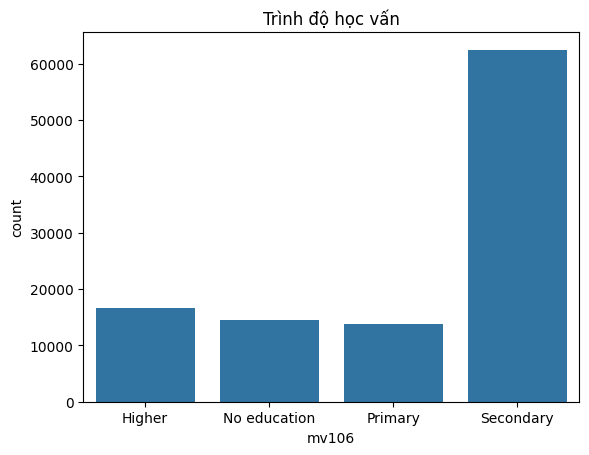

In [ ]:
sns.countplot(data=df, x='mv106', order=sorted(df['mv106'].dropna().unique()))
plt.title('Trình độ học vấn')


Text(0.5, 1.0, 'Tôn giáo')

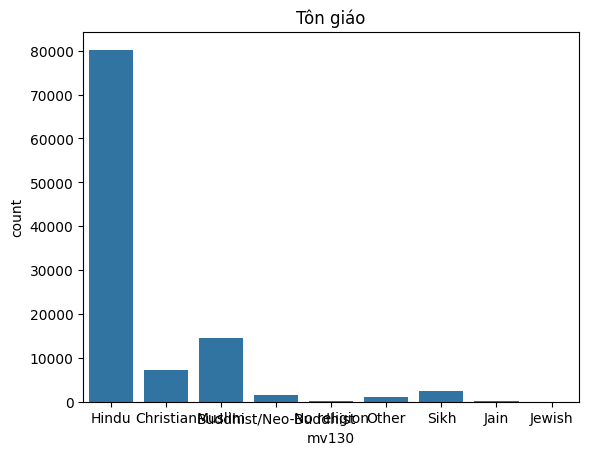

In [ ]:
sns.countplot(data=df, x='mv130')
plt.title('Tôn giáo')


Text(0.5, 1.0, 'Dân tộc')

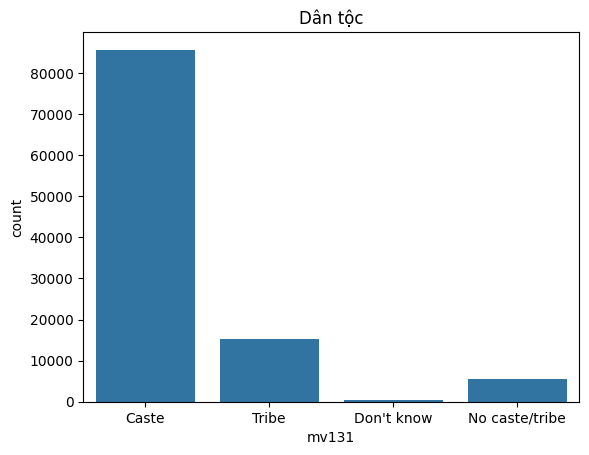

In [ ]:
sns.countplot(data=df, x='mv131')
plt.title('Dân tộc')


Text(0.5, 1.0, 'Tình trạng cư trú')

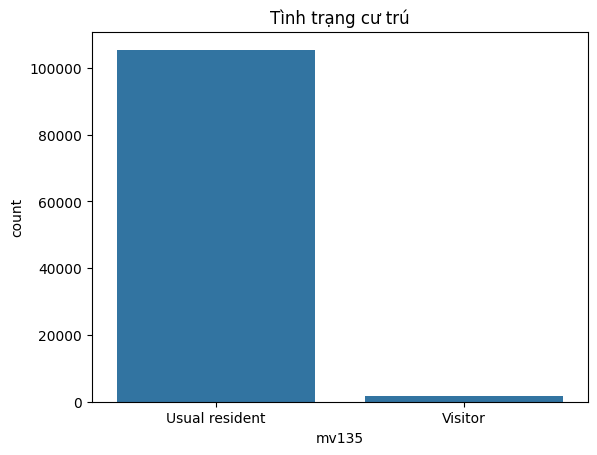

In [ ]:
sns.countplot(data=df, x='mv135')
plt.title('Tình trạng cư trú')


Text(0.5, 1.0, 'Số thành viên trong hộ')

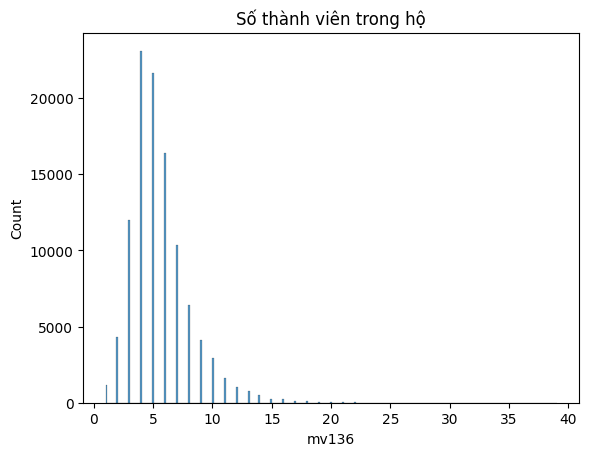

In [ ]:
sns.histplot(df['mv136'])
plt.title('Số thành viên trong hộ')


Text(0.5, 1.0, 'Số nam đủ điều kiện trong hộ')

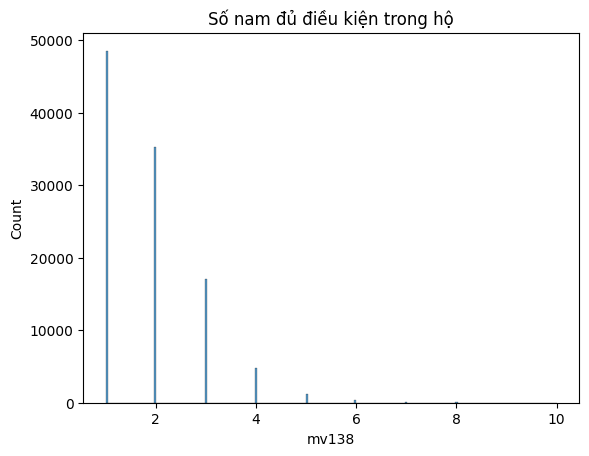

In [ ]:
sns.histplot(df['mv138'])
plt.title('Số nam đủ điều kiện trong hộ')


Text(0.5, 1.0, 'Phân bố Wealth Index (nhóm)')

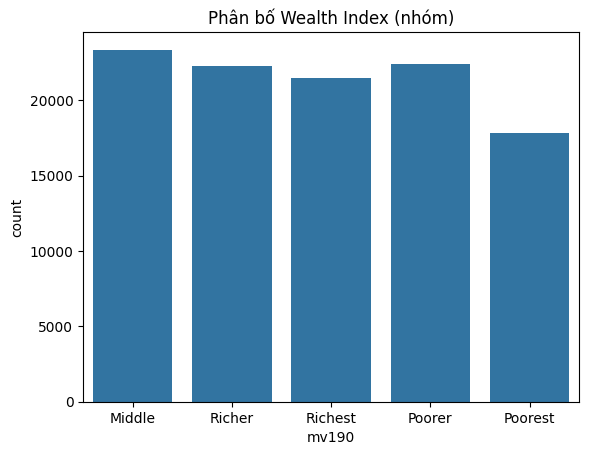

In [ ]:
sns.countplot(data=df, x='mv190')
plt.title('Phân bố Wealth Index (nhóm)')


Text(0.5, 1.0, 'Thuộc nhóm xã hội nào (caste/tribe/OBC)')

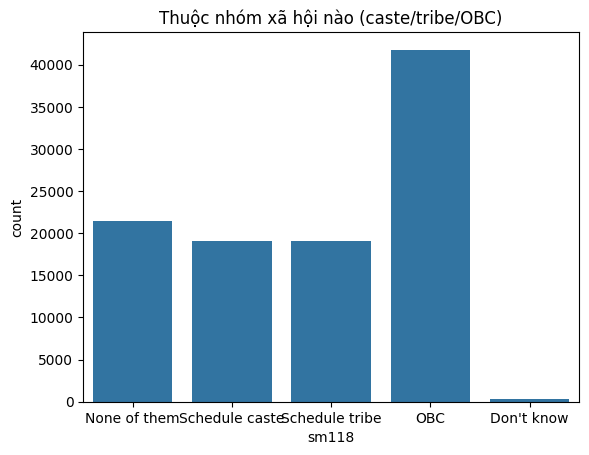

In [ ]:
sns.countplot(data=df, x='sm118')
plt.title('Thuộc nhóm xã hội nào (caste/tribe/OBC)')


### Sexual behavior

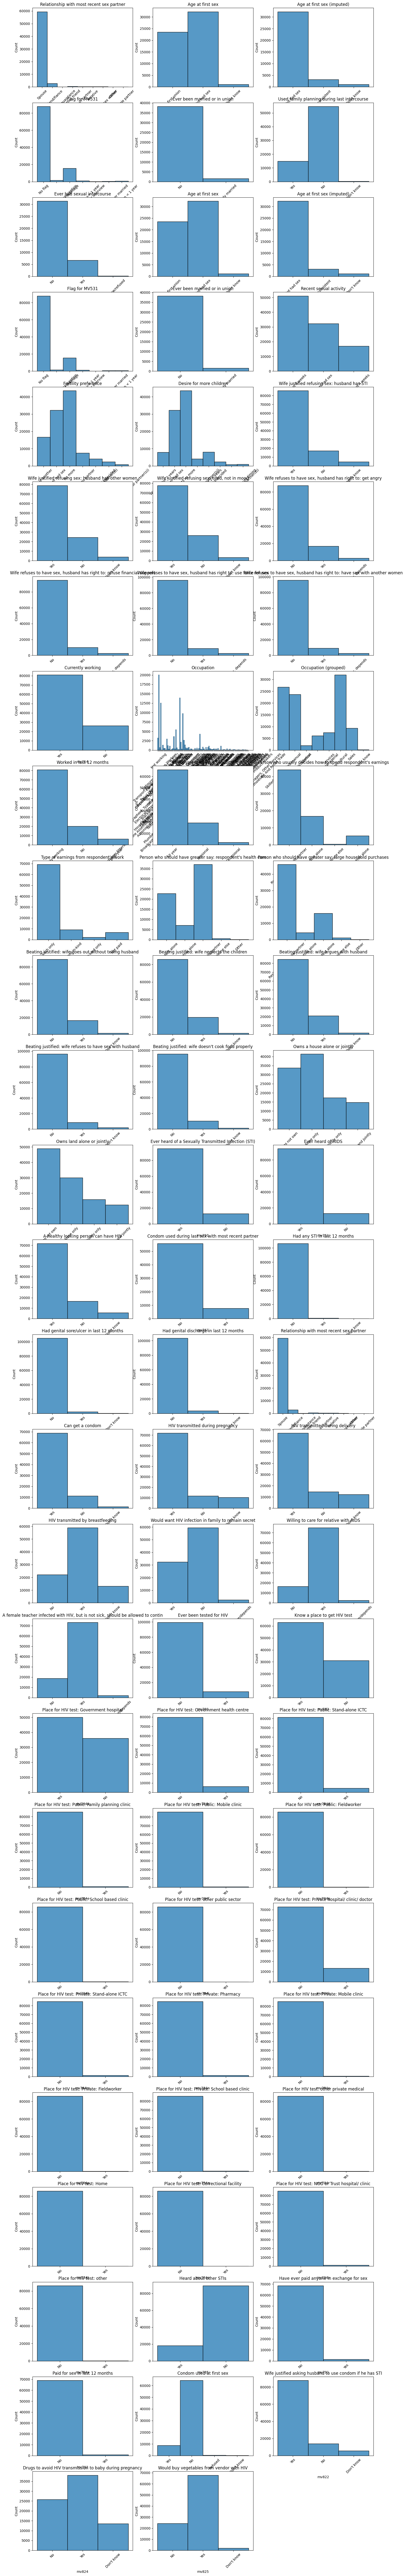

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

# Giả sử bạn đã có df chứa dữ liệu và df_map chứa 2 cột ori, conv
# df: DataFrame dữ liệu gốc
# df_map: DataFrame chứa cột ori (tên gốc) và conv (label)

# Hàm tạo các cột mở rộng từ mv525 đến mv529c
def expand_columns(prefix_start, prefix_end):
    base_cols = []
    for i in range(int(prefix_start), int(prefix_end) + 1):
        base_cols.append(f"mv{i}")
        # Thêm mv525a đến mv525z nếu có tồn tại
        for letter in string.ascii_lowercase:
            base_cols.append(f"mv{i}{letter}")
    return base_cols

# Các nhóm cột
cols_raw = [
    'mv766a', 'mv766b',
    'mv767a', 'mv767b', 'mv767c',
    *expand_columns(525, 535),  # mv525–mv535
    'mv836',
    'sm525', 'sm531',
    'sm228',
    *expand_columns(525, 829),  # mv525–mv829
]

# Lọc cột thực sự có mặt trong df_map
available_cols = [col for col in cols_raw if col in df_map['ori'].values and col in df.columns]

# Tạo mapping từ ori sang conv
label_dict = dict(zip(df_map['ori'], df_map['conv']))

# Tạo plots
n_cols = 3
n_plots = len(available_cols)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(available_cols):
    sns.histplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(label_dict.get(col, col))
    axes[i].tick_params(axis='x', rotation=45)

# Tắt các ô trống còn lại
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 2.2.4 Feature Selection - best 20 features

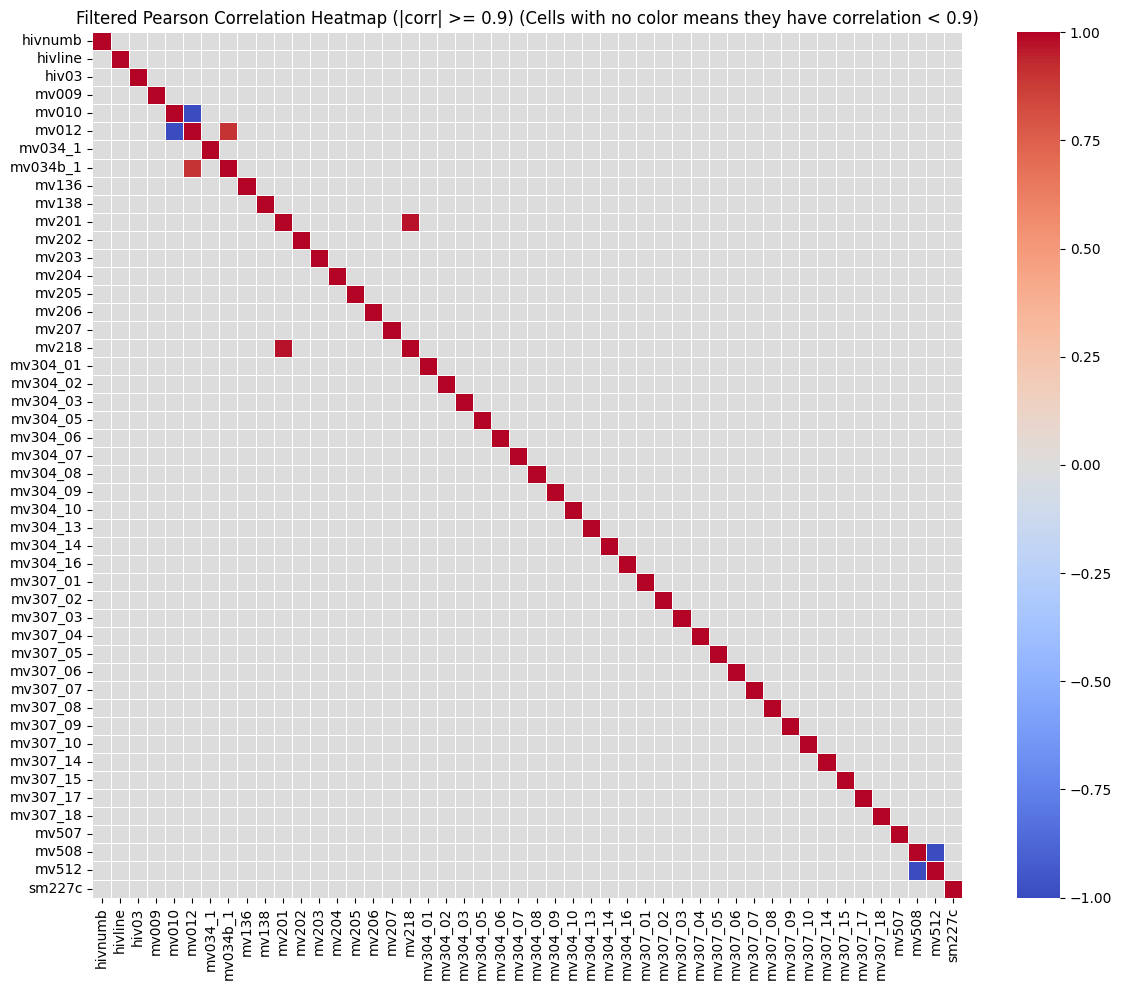

In [37]:
# Drop 1 of 2 highly correlated using pearson correlation
df_numeric = df.select_dtypes(include=[np.number])
corr_matrix = df_numeric.corr(method='pearson')
filtered_corr = corr_matrix.where(corr_matrix.abs() >= 0.9, 0)

plt.figure(figsize=(12, 10))
sns.heatmap(
    filtered_corr,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    annot=False,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Filtered Pearson Correlation Heatmap (|corr| >= 0.9) (Cells with no color means they have correlation < 0.9)")
plt.tight_layout()
plt.show()


In [38]:
def get_highly_correlated_pairs(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    pairs = [
        (col1, col2, upper.loc[col1, col2])
        for col1 in upper.columns
        for col2 in upper.index
        if not pd.isna(upper.loc[col1, col2]) and upper.loc[col1, col2] >= threshold
    ]
    return sorted(pairs, key=lambda x: -x[2])


def drop_more_missing_in_correlated_pairs(df, threshold=0.9):
    pairs = get_highly_correlated_pairs(df, threshold)
    to_drop = set()

    for col1, col2, _ in pairs:
        if col1 in to_drop or col2 in to_drop:
            continue

        n_missing1 = df[col1].isnull().sum()
        n_missing2 = df[col2].isnull().sum()
        print(f"Missing in {col1}: {n_missing1}, Missing in {col2}: {n_missing2}")
        if n_missing1 >= n_missing2:
            to_drop.add(col1)
        else:
            to_drop.add(col2)

    return df.drop(columns=list(to_drop)), list(to_drop)


df_cleaned, dropped = drop_more_missing_in_correlated_pairs(df_numeric, threshold=0.9)
print("Dropped:", dropped)


Missing in mv010: 0, Missing in mv012: 0
Missing in mv508: 39529, Missing in mv512: 39792
Missing in mv201: 0, Missing in mv218: 0
Missing in mv012: 0, Missing in mv034b_1: 39792
Dropped: ['mv034b_1', 'mv512', 'mv010', 'mv201']


In [39]:
df.drop(columns=dropped, inplace=True)
df.shape

(107294, 374)

In [40]:
# Caculate information value
def bin_continuous(df, col, bins=10):
    try:
        return pd.qcut(df[col], q=bins, duplicates='drop')
    except:
        return pd.cut(df[col], bins=bins)

def calc_woe_iv(df, feature, target):
    lst = []
    for val in df[feature].dropna().unique():
        total = len(df[df[feature] == val])
        good = len(df[(df[feature] == val) & (df[target] == 0)])
        bad = len(df[(df[feature] == val) & (df[target] == 1)])
        lst.append([val, total, good, bad])

    data = pd.DataFrame(lst, columns=['Value', 'Total', 'Good', 'Bad'])
    data['Distr_Good'] = data['Good'] / data['Good'].sum()
    data['Distr_Bad'] = data['Bad'] / data['Bad'].sum()
    data['WOE'] = np.log((data['Distr_Good'] + 1e-6) / (data['Distr_Bad'] + 1e-6))
    data['IV'] = (data['Distr_Good'] - data['Distr_Bad']) * data['WOE']
    iv = data['IV'].sum()
    return iv

def calculate_iv_all(df, target, categorical_features=[], continuous_features=[], bins=10):
    iv_dict = {}

    for feature in categorical_features:
        try:
            iv = calc_woe_iv(df, feature, target)
            iv_dict[feature] = iv
        except Exception as e:
            print(f"[Categorical] {feature} error: {e}")

    for feature in continuous_features:
        try:
            binned = bin_continuous(df, feature, bins)
            temp_df = df.copy()
            temp_df[feature + '_binned'] = binned
            iv = calc_woe_iv(temp_df, feature + '_binned', target)
            iv_dict[feature] = iv
        except Exception as e:
            print(f"[Continuous] {feature} error: {e}")

    return pd.Series(iv_dict).sort_values(ascending=False)


In [41]:
target = 'hiv03'
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
continuous_features = df.select_dtypes(include=['number']).columns.tolist()

iv_scores = calculate_iv_all(df, target=target,
                             categorical_features=categorical_features,
                             continuous_features=continuous_features,
                             bins=10)

print(iv_scores)

smlangrm    1.035439
mv716       1.023288
mv781       0.430595
mv510       0.413973
mv531       0.296546
              ...   
mv304_10    0.000000
mv304_13    0.000000
mv304_14    0.000000
mv304_16    0.000000
mv307_01    0.000000
Length: 374, dtype: float64


In [42]:
df_na = df.isna().sum().reset_index()

In [43]:
# Missing value ratio for each feature
df_na['rate'] = df_na[0] / len(df)
df_na.tail()

index      0     rate
369   sm190u  73859  0.68838
370  sm190us  73859  0.68838
371   sm190r  33435  0.31162
372  sm190rs  33435  0.31162
373  smphase      0  0.00000

In [44]:
df_iv = iv_scores.reset_index()
df_comp = pd.merge(df_iv, df_map, left_on='index', right_on='ori', how='inner')
df_comp = pd.merge(df_na, df_comp, on='index', how='inner')

In [45]:
df_comp.sort_values('0_y', ascending=False, inplace=True)

In [46]:
# Get feature with IV >= 0.02
df_comp[df_comp['0_y'] >= 0.02].head(30)


index    0_x      rate       0_y       ori  \
206  smlangrm      1  0.000009  1.035439  smlangrm   
121     mv716      0  0.000000  1.023288     mv716   
177     mv781      0  0.000000  0.430595     mv781   
104     mv510  39529  0.368418  0.413973     mv510   
107     mv531  70777  0.659655  0.296546     mv531   
2       mv013      0  0.000000  0.295040     mv013   
9       mv130      0  0.000000  0.284968     mv130   
59      mv312      0  0.000000  0.258475     mv312   
1       mv012      0  0.000000  0.252644     mv012   
212     sm228  69064  0.643689  0.242495     sm228   
109     mv535  67502  0.629131  0.197790     mv535   
169    mv767a  43901  0.409165  0.187838    mv767a   
178     mv783  13212  0.123138  0.184854     mv783   
111     mv602     79  0.000736  0.153461     mv602   
110     mv536   6993  0.065176  0.128322     mv536   
15      mv150      0  0.000000  0.126703     mv150   
112     mv605   7597  0.070805  0.109060     mv605   
341    sm812h  13212  0.123138  0.108267    sm812h   
364     sm213      0  0.000000  0.101756     sm213   
97      mv483      1  0.000009  0.098810     mv483   
4       mv025      0  0.000000  0.096558     mv025   
6       mv102      0  0.000000  0.096558     mv102   
122     mv717      0  0.000000  0.093550     mv717   
127    mv743a  39792  0.370869  0.092267    mv743a   
31      mv218      0  0.000000  0.092232     mv218   
198     mv785      1  0.000009  0.088667     mv785   
205     mv837  13212  0.123138  0.086381     mv837   
174     mv777  13212  0.123138  0.085885     mv777   
98      mv501      0  0.000000  0.083964     mv501   
99      mv502      0  0.000000  0.082990     mv502   

                                                  conv  
206                         Respondent's mother tongue  
121                                         Occupation  
177                           Ever been tested for HIV  
104          Completeness of date information in MV509  
107                         Age at first sex (imputed)  
2                                 Age in 5-year groups  
9                                             Religion  
59                        Current contraceptive method  
1                                          Current age  
212                        Ever had sexual intercourse  
109                      Ever been married or in union  
169          Relationship with most recent sex partner  
178                       Know a place to get HIV test  
111                               Fertility preference  
110                             Recent sexual activity  
15                      Relationship to household head  
112                           Desire for more children  
341  Ways to avoid HIV/AIDS: Avoid sex with persons...  
364                                 Currently in union  
97                              Respondent circumcised  
4                           Type of place of residence  
6                           Type of place of residence  
122                               Occupation (grouped)  
127  Person who should have greater say: respondent...  
31                           Number of living children  
198                             Heard about other STIs  
205  Heard of drugs to help HIV infected people liv...  
174  Would want HIV infection in family to remain s...  
98                 Current marital status  (see SM213)  
99                   Currently/formerly/never in union

In [47]:
# Define feature that actually has been asked in real clinics/hospitals with real patient
col_in_questionarire = [
    'mv012', 'smlangrm', 'mv104',
    'mv481', 'sm316', 'mv761',
    'sm321b', 'sm321c', 'sm321d', 'sm321h', 'sm812h', 'sm809',
    'mv480', 'mv793', 'mv826', 'mv826a', 'mv781'
]

In [48]:
# Get feature in practical that have IV >= 0.02
col_in_questionarire_choose = df_comp.loc[(df_comp['0_y'] >= 0.02) & (df_comp['ori'].isin(col_in_questionarire)), 'ori'].to_list()

In [49]:
combined_columns = list(set(df_comp.loc[(df_comp['0_y'] >= 0.08) & (df_comp['rate'] < .15)]['ori'].to_list() + col_in_questionarire_choose))
combined_columns

['mv781',
 'smlangrm',
 'mv605',
 'mv602',
 'mv025',
 'mv761',
 'mv312',
 'mv130',
 'sm213',
 'mv104',
 'mv777',
 'mv012',
 'mv837',
 'mv502',
 'sm321g',
 'mv102',
 'mv783',
 'sm812h',
 'mv150',
 'mv483',
 'mv536',
 'mv785',
 'sm609c',
 'mv716',
 'mv501',
 'mv013',
 'mv717',
 'mv218',
 'mv480']

In [50]:
# Final Feature selection
df_comp[df_comp['ori'].isin(combined_columns)]

index    0_x      rate       0_y       ori  \
206  smlangrm      1  0.000009  1.035439  smlangrm   
121     mv716      0  0.000000  1.023288     mv716   
177     mv781      0  0.000000  0.430595     mv781   
2       mv013      0  0.000000  0.295040     mv013   
9       mv130      0  0.000000  0.284968     mv130   
59      mv312      0  0.000000  0.258475     mv312   
1       mv012      0  0.000000  0.252644     mv012   
178     mv783  13212  0.123138  0.184854     mv783   
111     mv602     79  0.000736  0.153461     mv602   
110     mv536   6993  0.065176  0.128322     mv536   
15      mv150      0  0.000000  0.126703     mv150   
112     mv605   7597  0.070805  0.109060     mv605   
341    sm812h  13212  0.123138  0.108267    sm812h   
364     sm213      0  0.000000  0.101756     sm213   
97      mv483      1  0.000009  0.098810     mv483   
4       mv025      0  0.000000  0.096558     mv025   
6       mv102      0  0.000000  0.096558     mv102   
122     mv717      0  0.000000  0.093550     mv717   
31      mv218      0  0.000000  0.092232     mv218   
198     mv785      1  0.000009  0.088667     mv785   
205     mv837  13212  0.123138  0.086381     mv837   
174     mv777  13212  0.123138  0.085885     mv777   
98      mv501      0  0.000000  0.083964     mv501   
99      mv502      0  0.000000  0.082990     mv502   
276    sm609c      0  0.000000  0.081694    sm609c   
265    sm321g      0  0.000000  0.080938    sm321g   
141     mv761  43901  0.409165  0.060594     mv761   
87      mv480  60369  0.562650  0.045602     mv480   
7       mv104  33946  0.316383  0.021829     mv104   

                                                  conv  
206                         Respondent's mother tongue  
121                                         Occupation  
177                           Ever been tested for HIV  
2                                 Age in 5-year groups  
9                                             Religion  
59                        Current contraceptive method  
1                                          Current age  
178                       Know a place to get HIV test  
111                               Fertility preference  
110                             Recent sexual activity  
15                      Relationship to household head  
112                           Desire for more children  
341  Ways to avoid HIV/AIDS: Avoid sex with persons...  
364                                 Currently in union  
97                              Respondent circumcised  
4                           Type of place of residence  
6                           Type of place of residence  
122                               Occupation (grouped)  
31                           Number of living children  
198                             Heard about other STIs  
205  Heard of drugs to help HIV infected people liv...  
174  Would want HIV infection in family to remain s...  
98                 Current marital status  (see SM213)  
99                   Currently/formerly/never in union  
276                       Type of tobacco used: Hookah  
265       Service went for: Growth monitoring of child  
141  Condom used during last sex with most recent p...  
87       Syringe and needle from new, unopened package  
7                    Years lived in place of residence

In [56]:
col_to_drop = [ 'mv013', 'mv102', 'mv717',]
combined_columns = [col for col in combined_columns if col not in col_to_drop]
final_columns = df_comp[df_comp['ori'].isin(combined_columns)]['ori'].values

In [57]:
final_columns.shape

(26,)

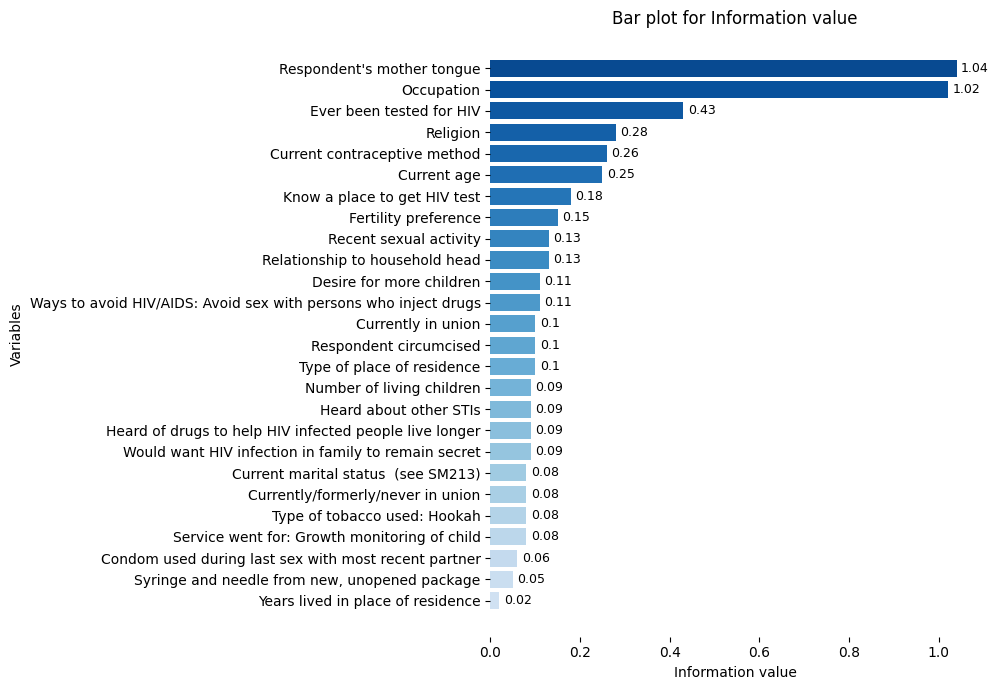

In [58]:

df_plot = df_comp[df_comp['ori'].isin(final_columns)].copy().sort_values('0_y', ascending=False)
df_plot['0_y'] = df_plot['0_y'].round(2)
cmap = plt.cm.Blues
colors = cmap(np.linspace(0.2, 0.9, len(df_plot)))[::-1]

plt.figure(figsize=(10, 7))
bars = plt.barh(df_plot['conv'], df_plot['0_y'], color=colors)

for bar, value in zip(bars, df_plot['0_y']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             str(value),
             va='center', ha='left', fontsize=9)

for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)


plt.xlabel('Information value')
plt.ylabel('Variables')
plt.title('Bar plot for Information value')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 2.2.5 EDA for finale variables

In [59]:
df_map[df_map['ori'].isin(final_columns)]['conv'].values

array(['Current age', 'Type of place of residence',
       'Years lived in place of residence', 'Religion',
       'Relationship to household head', 'Number of living children',
       'Current contraceptive method',
       'Syringe and needle from new, unopened package',
       'Respondent circumcised', 'Current marital status  (see SM213)',
       'Currently/formerly/never in union', 'Recent sexual activity',
       'Fertility preference', 'Desire for more children', 'Occupation',
       'Condom used during last sex with most recent partner',
       'Would want HIV infection in family to remain secret',
       'Ever been tested for HIV', 'Know a place to get HIV test',
       'Heard about other STIs',
       'Heard of drugs to help HIV infected people live longer',
       "Respondent's mother tongue",
       'Service went for: Growth monitoring of child',
       'Type of tobacco used: Hookah',
       'Ways to avoid HIV/AIDS: Avoid sex with persons who inject drugs',
       'Currently

In [ ]:
# Current age, Type of place of residence,Number of household members (total listed),Years lived in place of residence, Religion,Relationship to household head, Number of living children,Current contraceptive method,Syringe and needle from new, unopened package,Respondent circumcised, Fertility preference, Occupation,Condom used during last sex with most recent partner,Would want HIV infection in family to remain secret,Ever been tested for HIV, Know a place to get HIV test,"Respondents mother tongue",Service went for: Growth monitoring of child,Type of tobacco used: Hookah,Ways to avoid HIV/AIDS: Avoid sex with persons who inject drugs

In [ ]:
final_columns = ['smlangrm', 'mv716', 'mv781', 'mv130', 'mv312', 'mv783', 'mv012',
       'mv150', 'mv218', 'mv777', 'mv483', 'sm812h', 'sm321g', 'mv602',
       'sm609c', 'mv136', 'mv025', 'mv480', 'mv761', 'mv104']

In [60]:
len(final_columns)

26

In [61]:
df_eda = df[final_columns].copy(deep=True)
df_eda = df[['hiv03']].join(df_eda)
print(df_eda.shape)
df_eda.head()

(107294, 27)


hiv03 smlangrm                                              mv716 mv781  \
0      0   Telugu             Transport Equipment Operators (Driver)    No   
1      0    Tamil                                        Not working    No   
2      0   Telugu  Machinery Fitters, Machine Assemblers And Prec...    No   
3      0   Telugu                      Labourers (Labourers, N.E.C.)   Yes   
4      0    Tamil  Stenographers, Typist And Card And Tape Punchi...    No   

       mv130       mv312  mv012 mv783               mv602  \
0      Hindu  Withdrawal     28   Yes        Have another   
1      Hindu   Not using     16   Yes       Never had sex   
2  Christian  Withdrawal     44   Yes             No more   
3  Christian   Not using     23   Yes  Man has no partner   
4      Hindu  Withdrawal     20   Yes  Man has no partner   

                    mv536  ... mv785 mv837 mv777  \
0  Active in last 4 weeks  ...   Yes   Yes   Yes   
1           Never had sex  ...   Yes    No    No   
2  Active in last 4 weeks  ...    No    No    No   
3  Active in last 4 weeks  ...   Yes   Yes    No   
4  Active in last 4 weeks  ...   Yes   Yes    No   

                                               mv501  \
0                                            Married   
1  Never in union [includes: married gauna not pe...   
2                                            Married   
3  Never in union [includes: married gauna not pe...   
4  Never in union [includes: married gauna not pe...   

                                               mv502 sm609c  sm321g mv761  \
0             Currently in union/living with a woman     No      No    No   
1  Never in union [includes: married gauna not pe...     No      No   NaN   
2             Currently in union/living with a woman     No      No    No   
3  Never in union [includes: married gauna not pe...     No      No    No   
4  Never in union [includes: married gauna not pe...     No      No   Yes   

  mv480   mv104  
0   NaN     NaN  
1   NaN  Always  
2   NaN     NaN  
3   Yes  Always  
4   Yes     NaN  

[5 rows x 27 columns]

In [62]:
df_eda.columns = [df_map.loc[df_map['ori'] == c, 'conv'].values[0] if c != 'hiv03' else 'label' for c in df_eda.columns]
df_eda.head(1)

label Respondent's mother tongue                              Occupation  \
0      0                     Telugu  Transport Equipment Operators (Driver)   

  Ever been tested for HIV Religion Current contraceptive method  Current age  \
0                       No    Hindu                   Withdrawal           28   

  Know a place to get HIV test Fertility preference  Recent sexual activity  \
0                          Yes         Have another  Active in last 4 weeks   

   ... Heard about other STIs  \
0  ...                    Yes   

  Heard of drugs to help HIV infected people live longer  \
0                                                Yes       

  Would want HIV infection in family to remain secret  \
0                                                Yes    

  Current marital status  (see SM213)       Currently/formerly/never in union  \
0                             Married  Currently in union/living with a woman   

  Type of tobacco used: Hookah  Service went for: Growth monitoring of child  \
0                           No                                            No   

  Condom used during last sex with most recent partner  \
0                                                 No     

  Syringe and needle from new, unopened package  \
0                                           NaN   

  Years lived in place of residence  
0                               NaN  

[1 rows x 27 columns]

In [63]:
df_eda['label'] = df_eda['label'].astype('category')
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107294 entries, 0 to 107296
Data columns (total 27 columns):
 #   Column                                                           Non-Null Count   Dtype   
---  ------                                                           --------------   -----   
 0   label                                                            107294 non-null  category
 1   Respondent's mother tongue                                       107293 non-null  object  
 2   Occupation                                                       107294 non-null  object  
 3   Ever been tested for HIV                                         107294 non-null  object  
 4   Religion                                                         107294 non-null  object  
 5   Current contraceptive method                                     107294 non-null  object  
 6   Current age                                                      107294 non-null  int64   
 7   Know a place to get HIV t

In [64]:
for c in df_eda.columns:
  print(df_eda[c].dtype)
  print(df_eda[c].value_counts())
  print('-' * 50)

category
label
0    107058
1       236
Name: count, dtype: int64
--------------------------------------------------
object
Respondent's mother tongue
Hindi        52142
Other         7173
Gujarati      5815
Tamil         5514
Bengali       4473
Oriya         4283
Marathi       4194
Kannada       3264
Punjabi       3237
Assamese      2727
Telugu        2715
Kashmiri      2679
Malayalam     2325
Mizoram       1372
Urdu          1285
Manipuri      1230
Nepali         738
English        694
Konkani        488
Khasi          484
Garo           450
Sindhi          11
Name: count, dtype: int64
--------------------------------------------------
object
Occupation
Not working                                            20007
Agricultural Labourer                                  13933
Labourers (Labourers, N.E.C.)                          12537
Farmers, Other Than Cultivators                         9750
Cultivators                                             5477
                                

### Univariate Analysis

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Adjust visual style
sns.set(style="whitegrid")

# Step 1: Detect feature types
def univariate_analysis(df):
    numeric_features = df.select_dtypes(include=['number']).columns
    categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns

    # Step 2: Plot numeric features
    for feature in numeric_features:
        plt.figure(figsize=(10, 4))

        # Histogram + KDE
        sns.histplot(df[feature].dropna(), kde=True, bins=30, color='blue')
        plt.title(f"Histogram & Density for {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    # Step 3: Plot categorical features
    for feature in categorical_features:
        plt.figure(figsize=(8, 4))

        # Bar plot
        df[feature].value_counts(dropna=False).plot(kind='bar', color='salmon')
        plt.title(f"Bar Plot for {feature}")
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


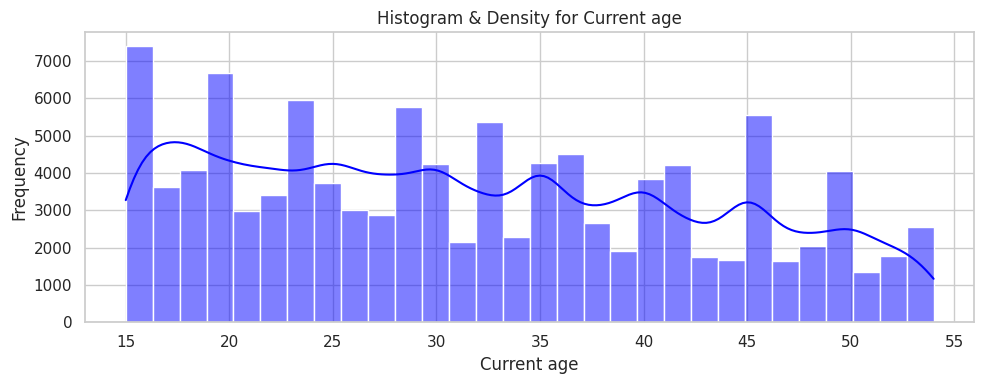

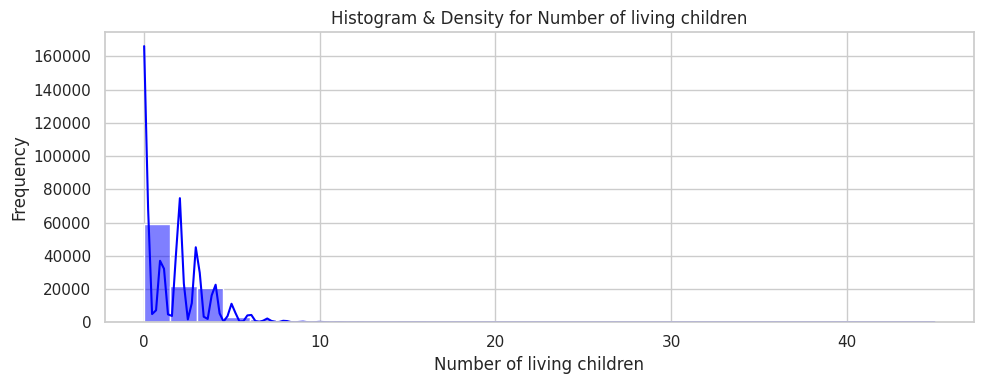

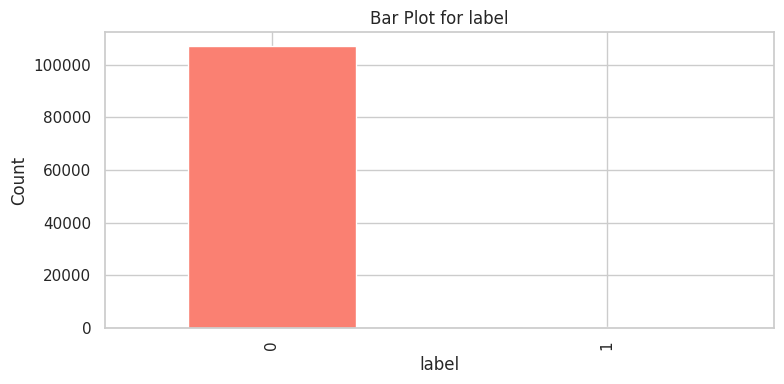

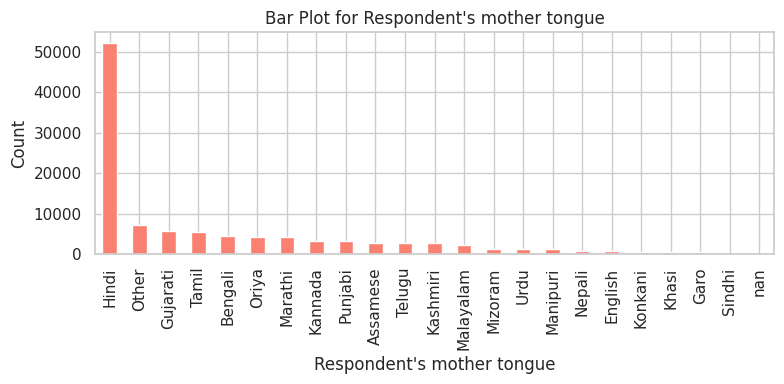

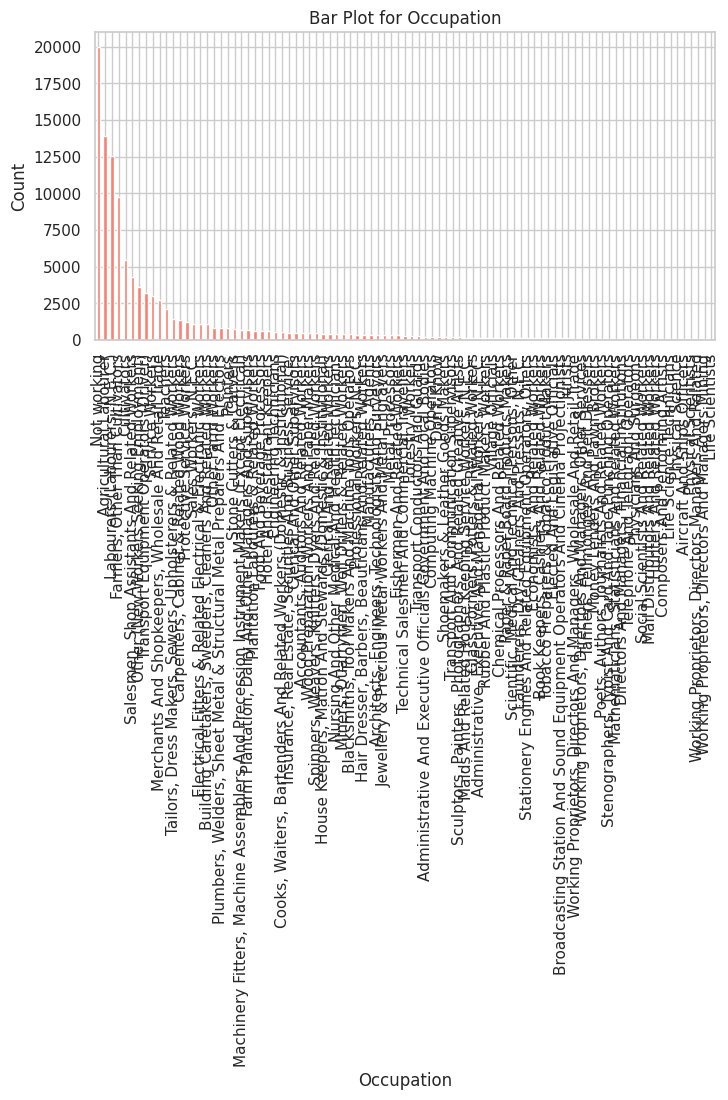

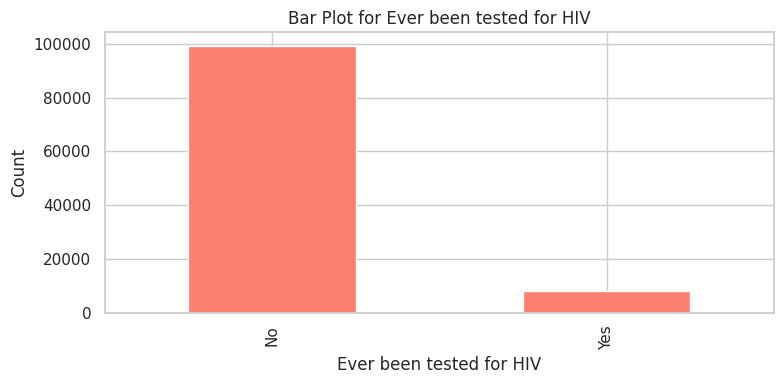

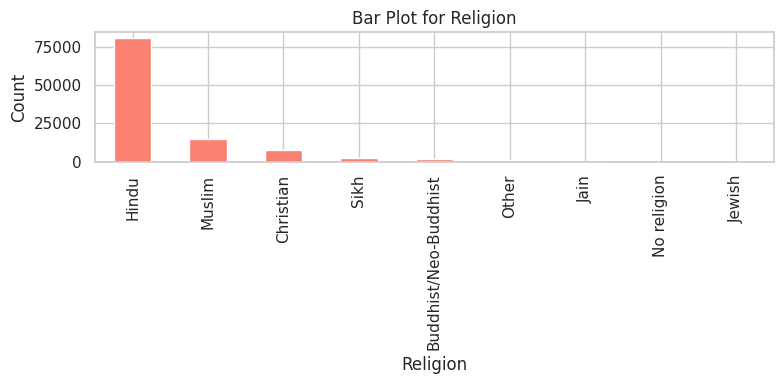

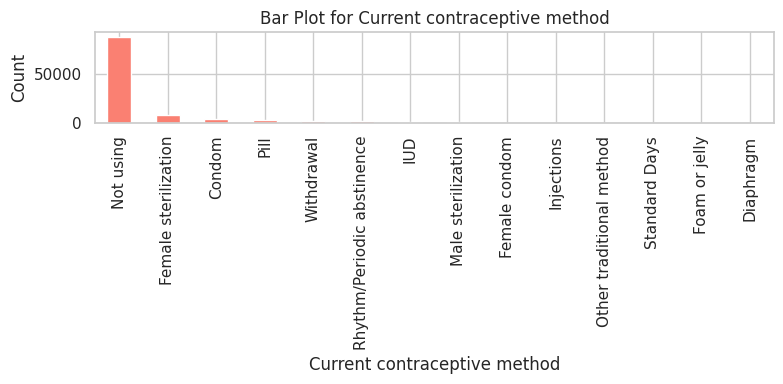

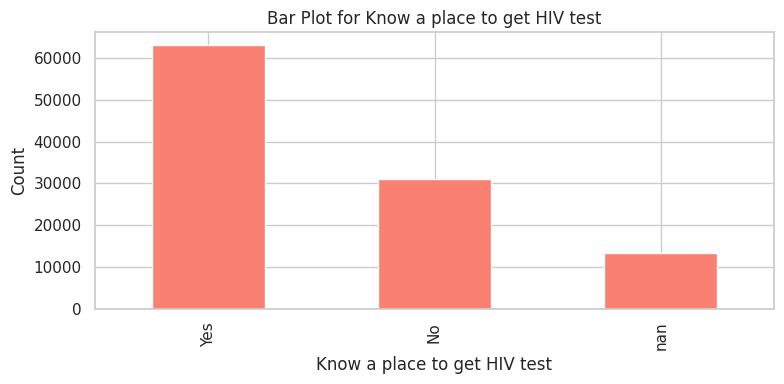

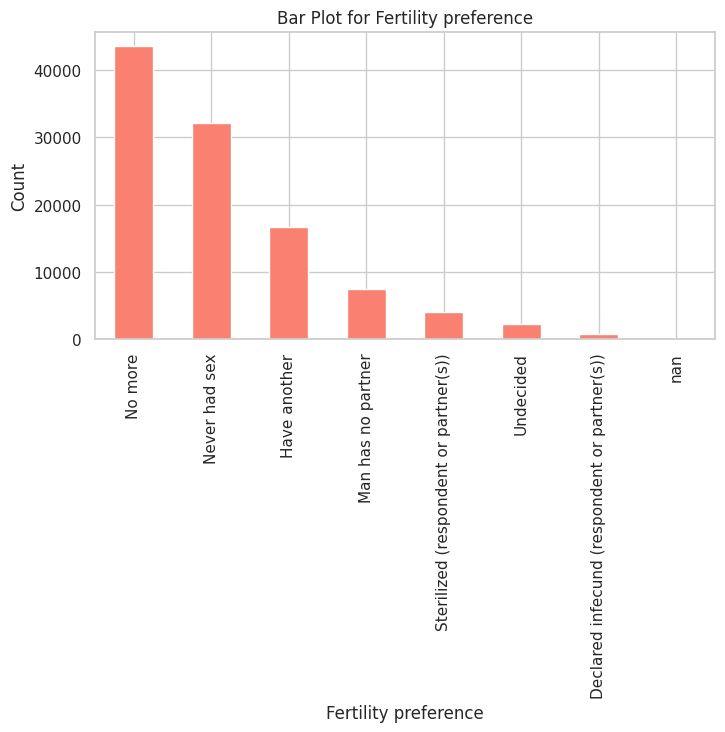

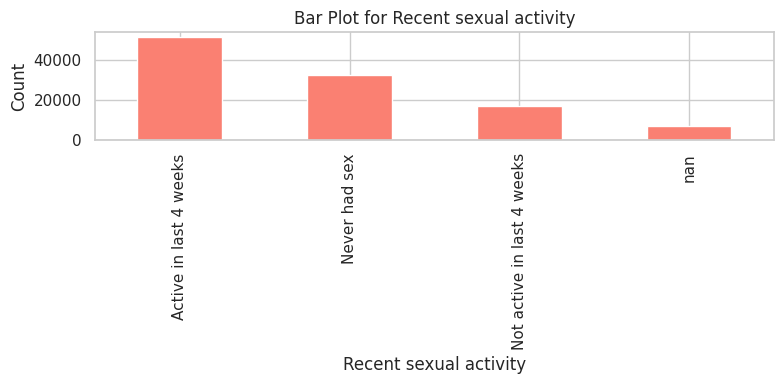

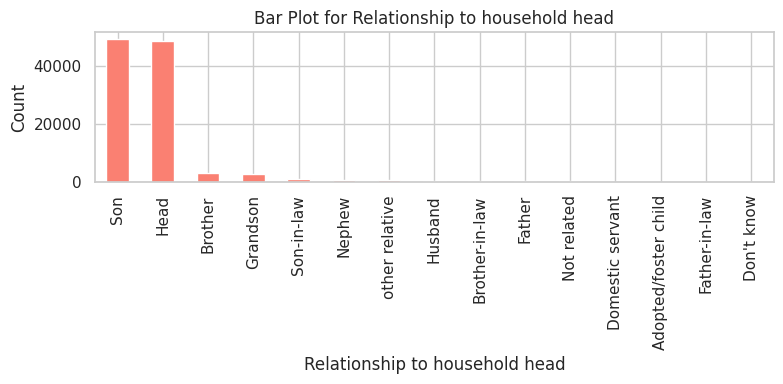

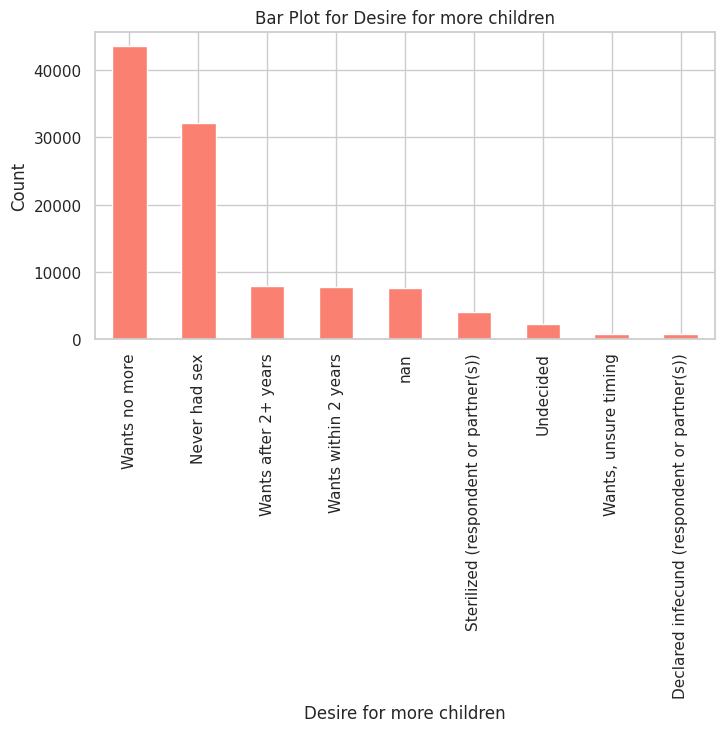

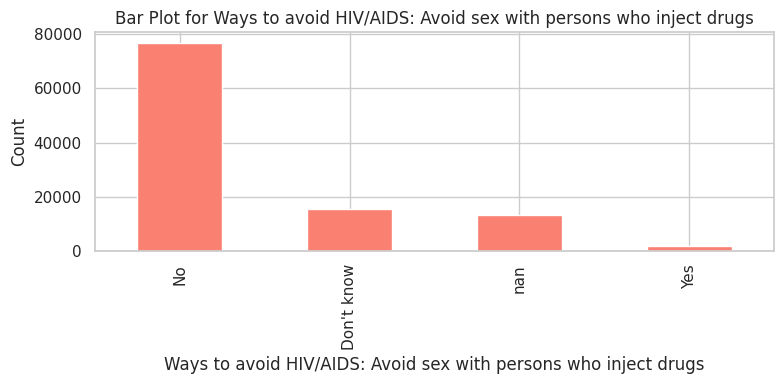

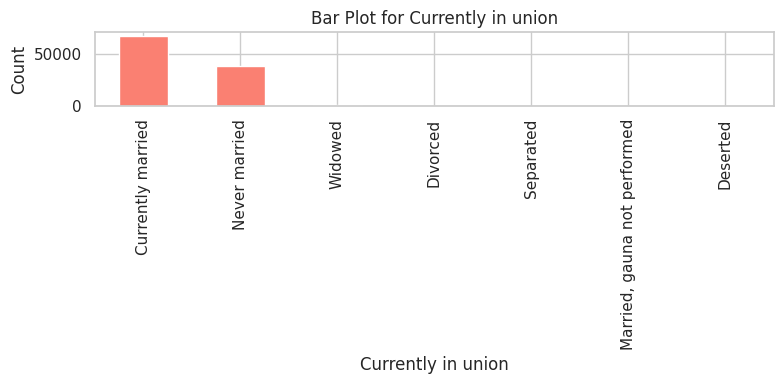

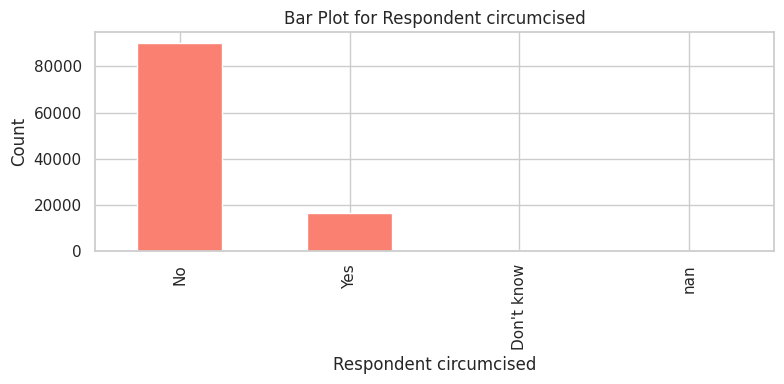

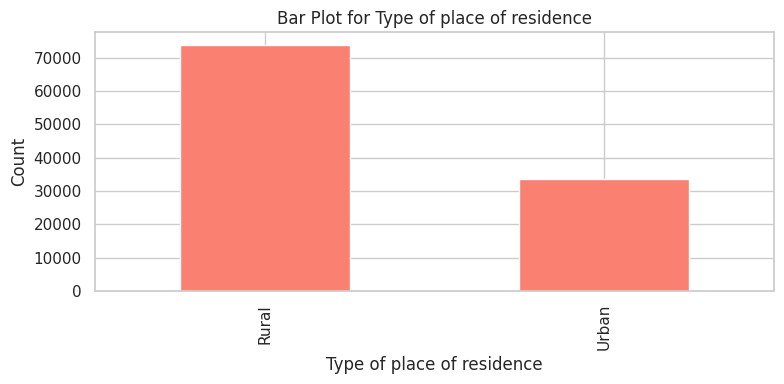

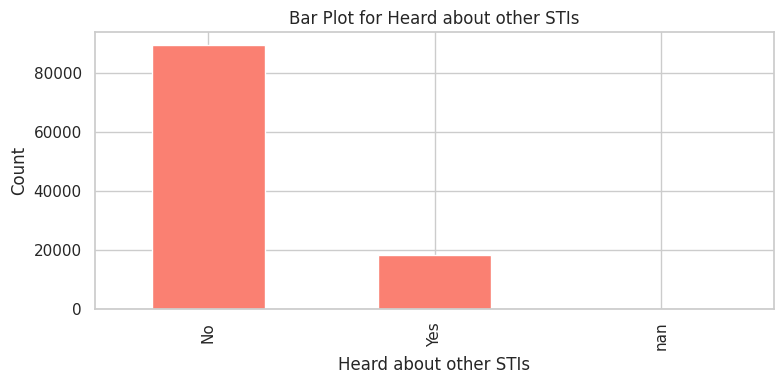

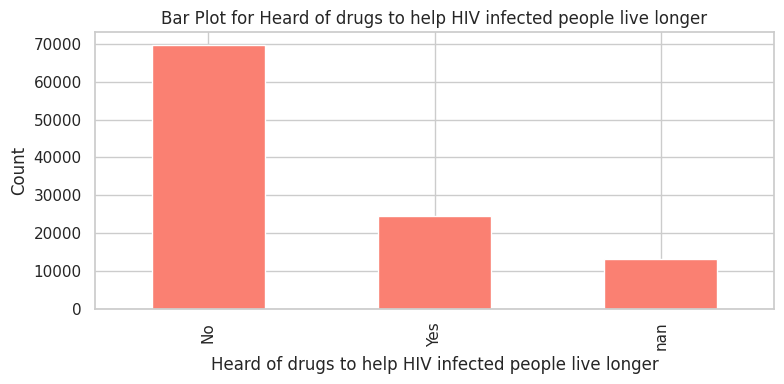

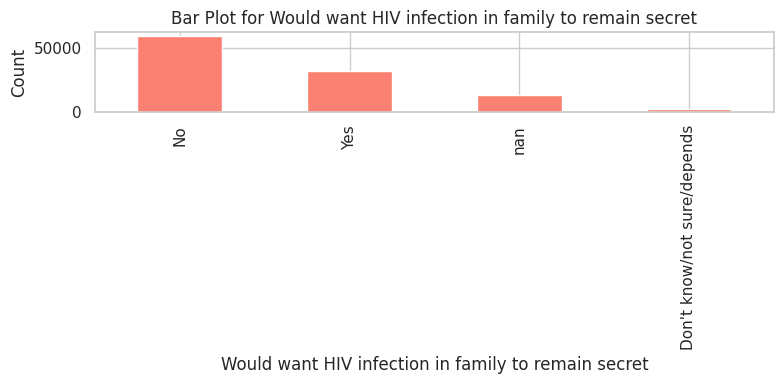

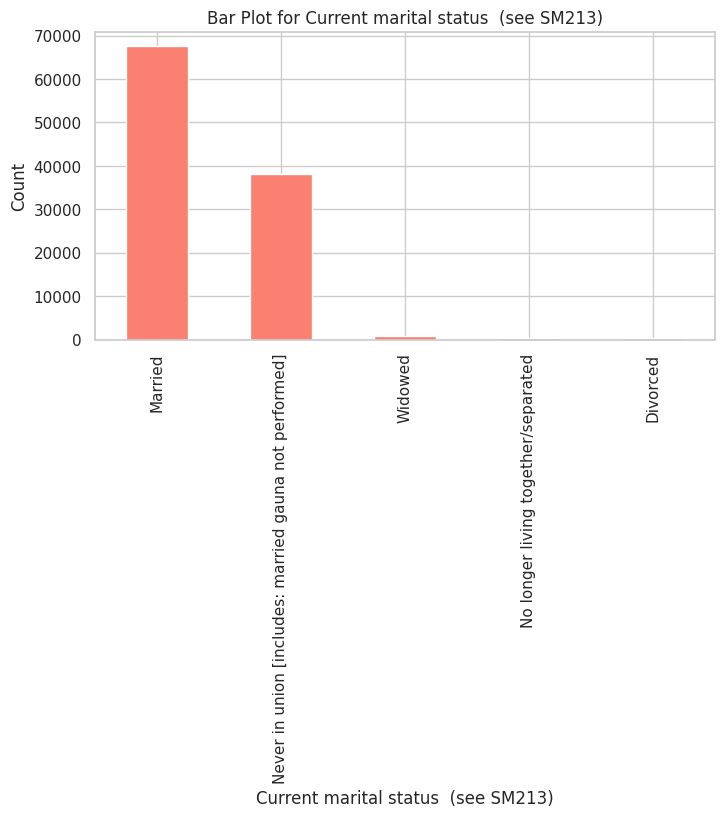

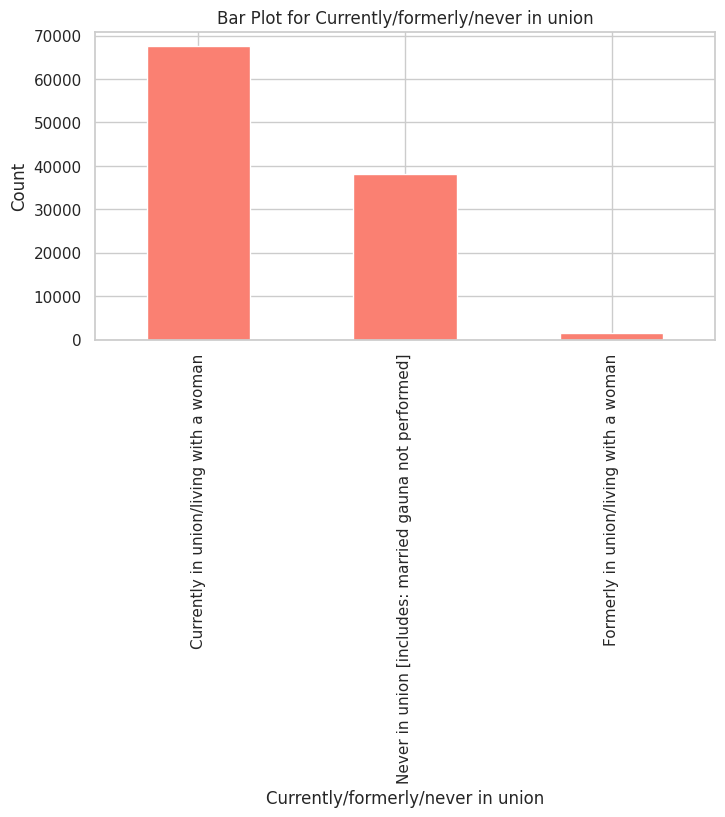

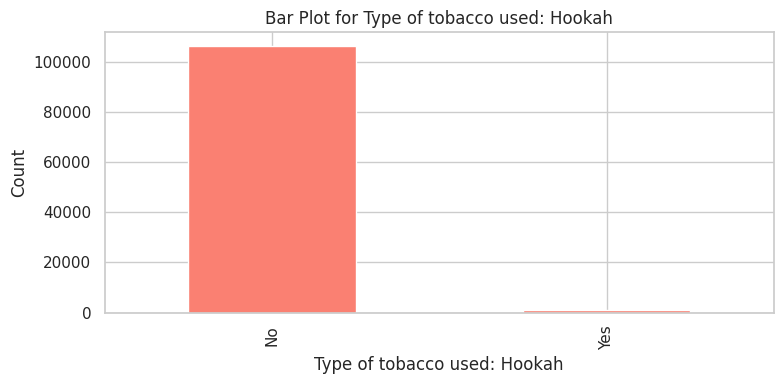

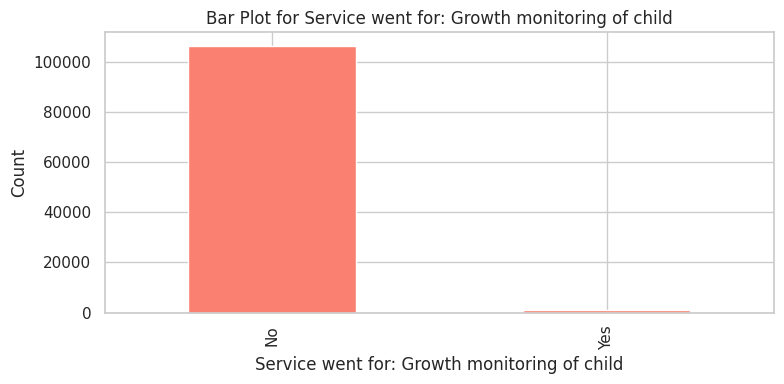

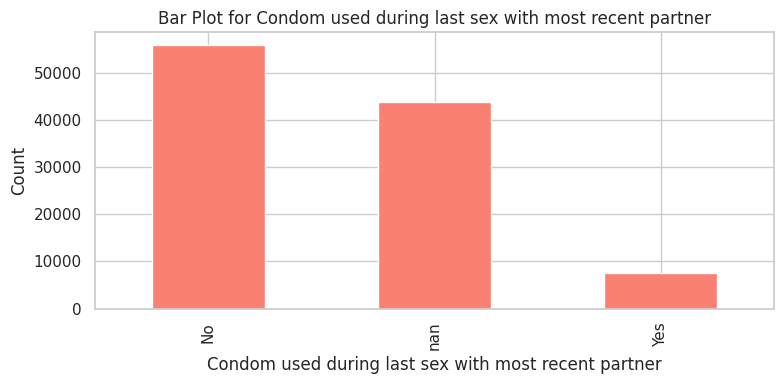

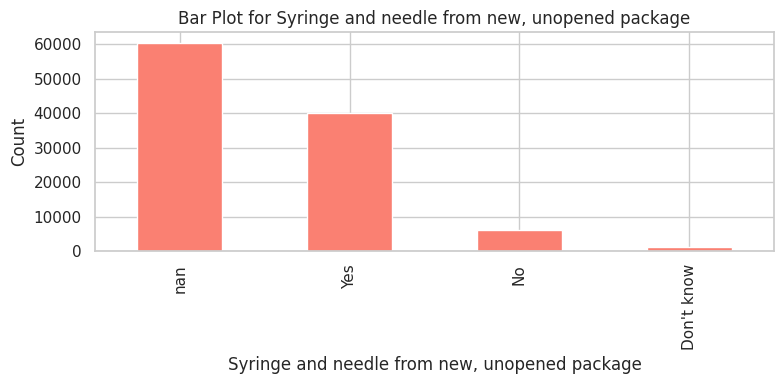

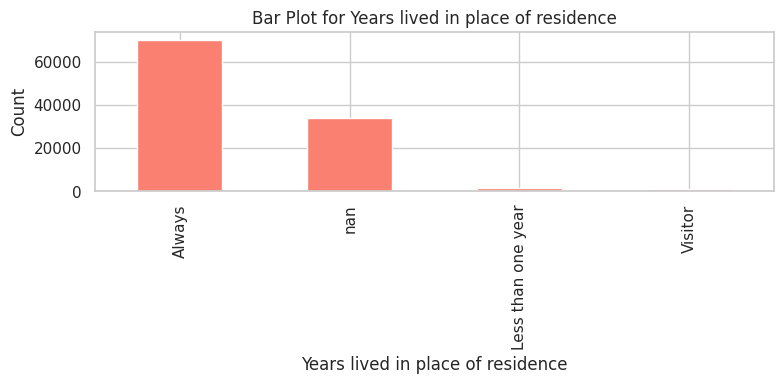

In [66]:
univariate_analysis(df_eda)

### Multivariate analysis

In [67]:
num_cols = [c for c in df_eda.columns if df_eda[c].dtype == 'int64' or df_eda[c].dtype == 'float64']
cat_cols = [c for c in df_eda.columns if df_eda[c].dtype in ['object'] and c != 'label']

In [68]:
def scatter_plot(df, x, y):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.6, color='teal')
    plt.title(f'Scatter Plot: {x} vs {y}')
    plt.tight_layout()
    plt.show()

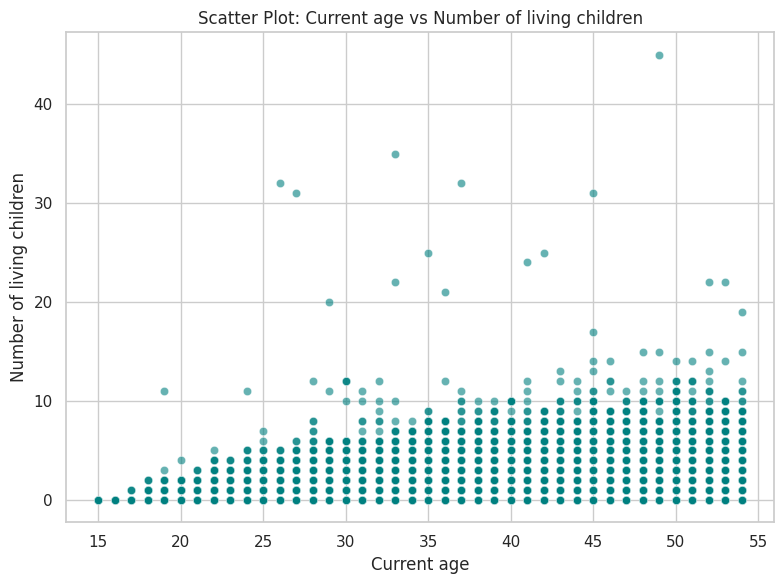

In [69]:
for c1 in range(len(num_cols) - 1):
  for c2 in range(c1 + 1, len(num_cols)):
    scatter_plot(df_eda, num_cols[c1], num_cols[c2])

In [70]:
def box_violin_plot(df, x_cat, y_num):
    plt.figure(figsize=(16, 6))

    # Box Plot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x=x_cat, y=y_num, palette='pastel')
    plt.title(f'Box Plot: {y_num} by {x_cat}')

    # Violin Plot
    plt.subplot(1, 2, 2)
    sns.violinplot(data=df, x=x_cat, y=y_num, palette='muted')
    plt.title(f'Violin Plot: {y_num} by {x_cat}')

    plt.tight_layout()
    plt.show()


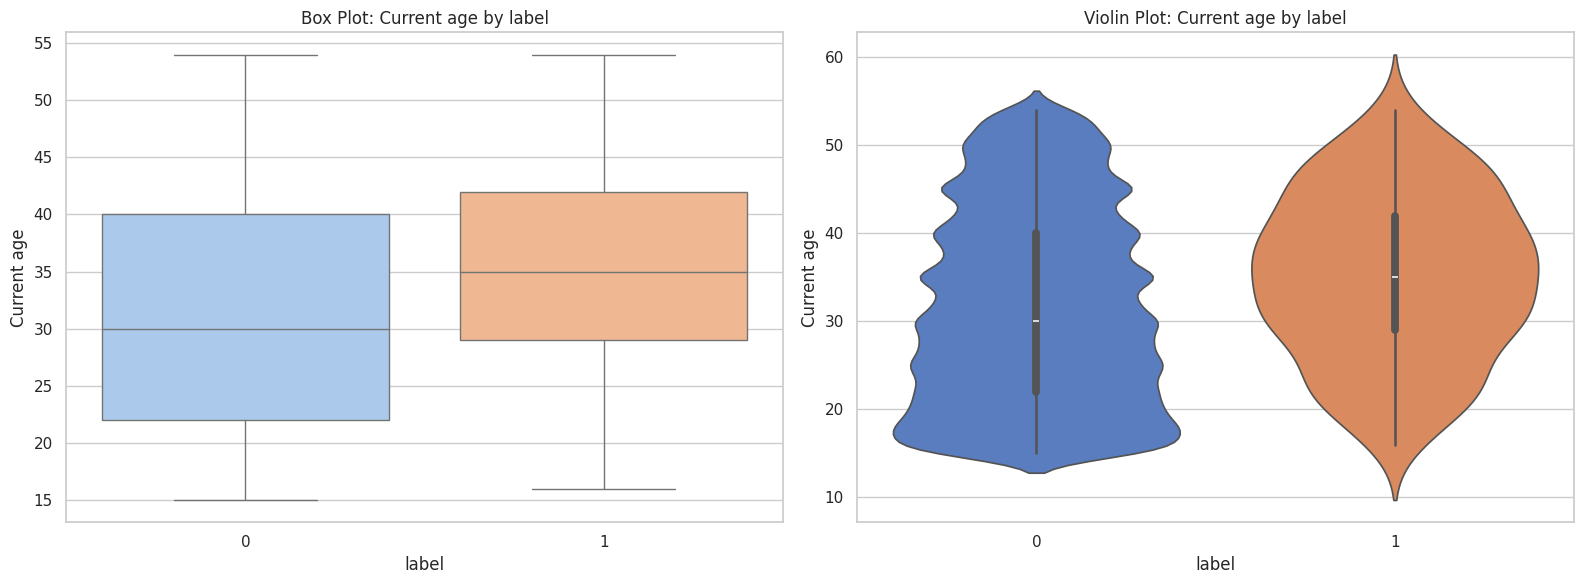

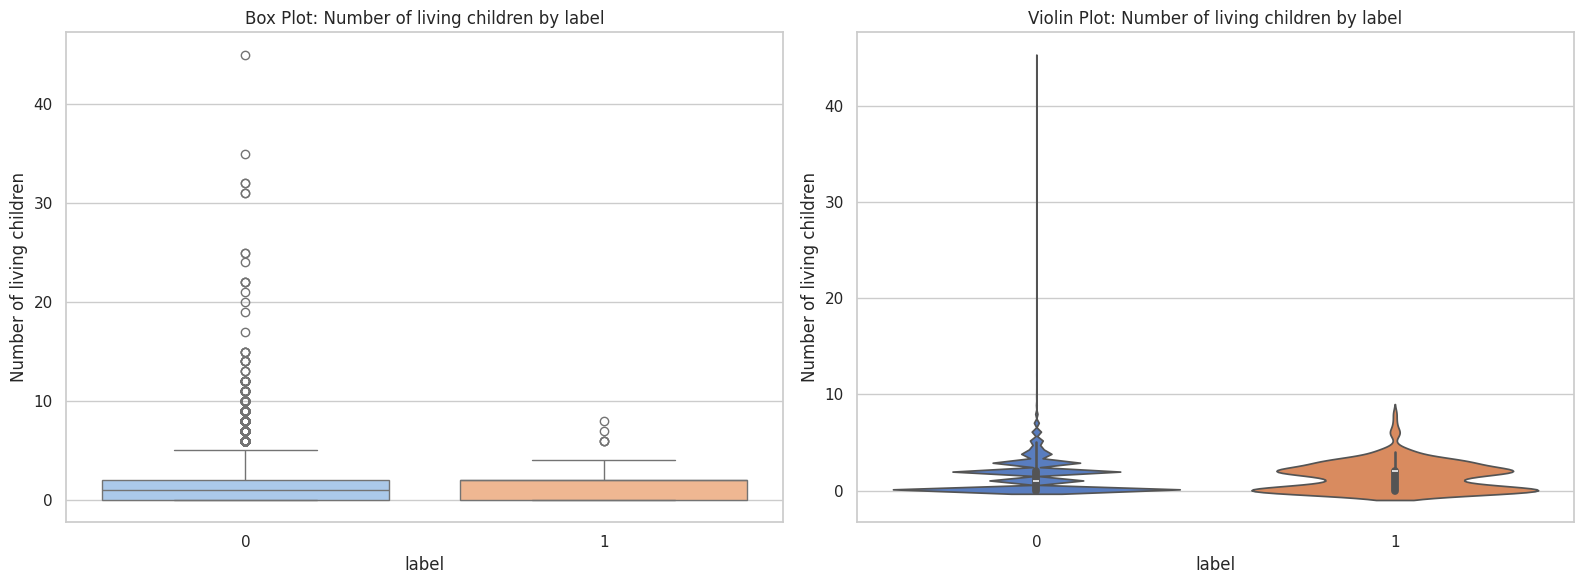

In [71]:
for c in num_cols:
  box_violin_plot(df_eda, 'label', c)

In [72]:
def histograms_by_label(df, label_col):
    numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=[label_col], errors='ignore').columns

    for feature in numeric_features:
        plt.figure(figsize=(10, 5))
        sns.histplot(data=df, x=feature, hue=label_col, kde=True, element="step", stat="density", common_norm=False)
        plt.title(f'Histogram of {feature} by {label_col}')
        plt.tight_layout()
        plt.show()


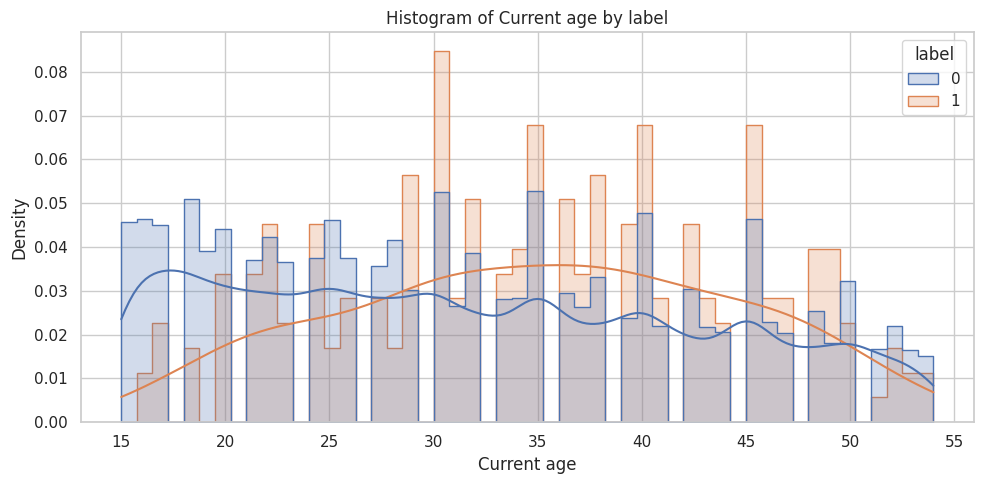

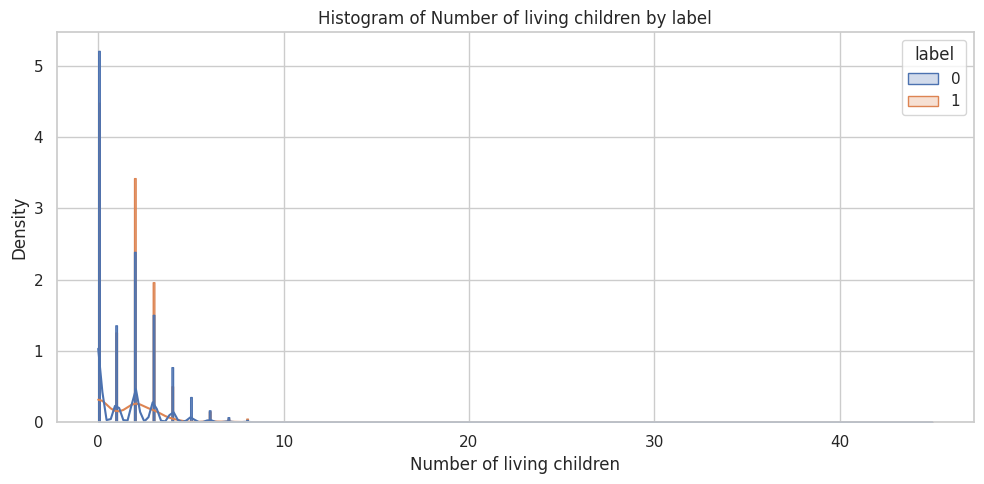

In [73]:
histograms_by_label(df_eda, 'label')

In [74]:
def barplots_by_label(df, label_col):
    cat_features = df.select_dtypes(include=['object', 'bool']).columns

    for feature in cat_features:
        # Count occurrences for each (label, feature category)
        counts = df.groupby([label_col, feature]).size().reset_index(name='count')

        # Total per label (0, 1)
        total_per_label = counts.groupby(label_col)['count'].transform('sum')

        # Compute percentage within each label
        counts['percentage'] = 100 * counts['count'] / total_per_label

        # Plot
        plt.figure(figsize=(8, 5))
        sns.barplot(data=counts, x=feature, y='percentage', hue=label_col, palette='Set2')

        plt.title(f'{feature} distribution (%) within each label')
        plt.ylabel('Percentage (%)')
        plt.xlabel(feature)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

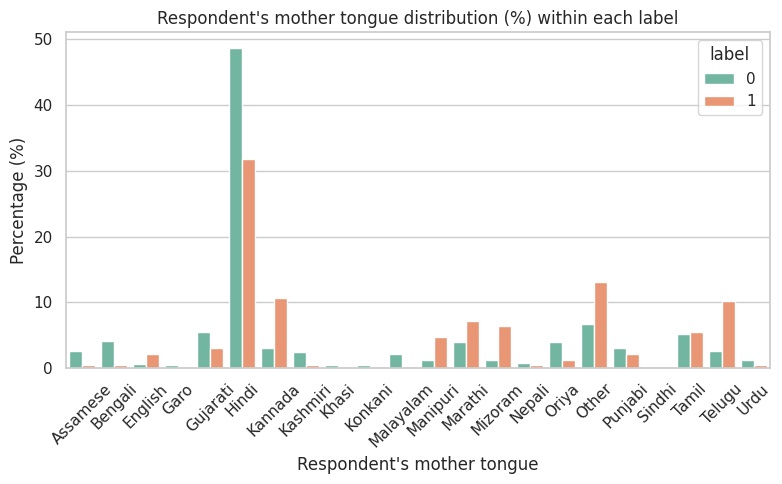

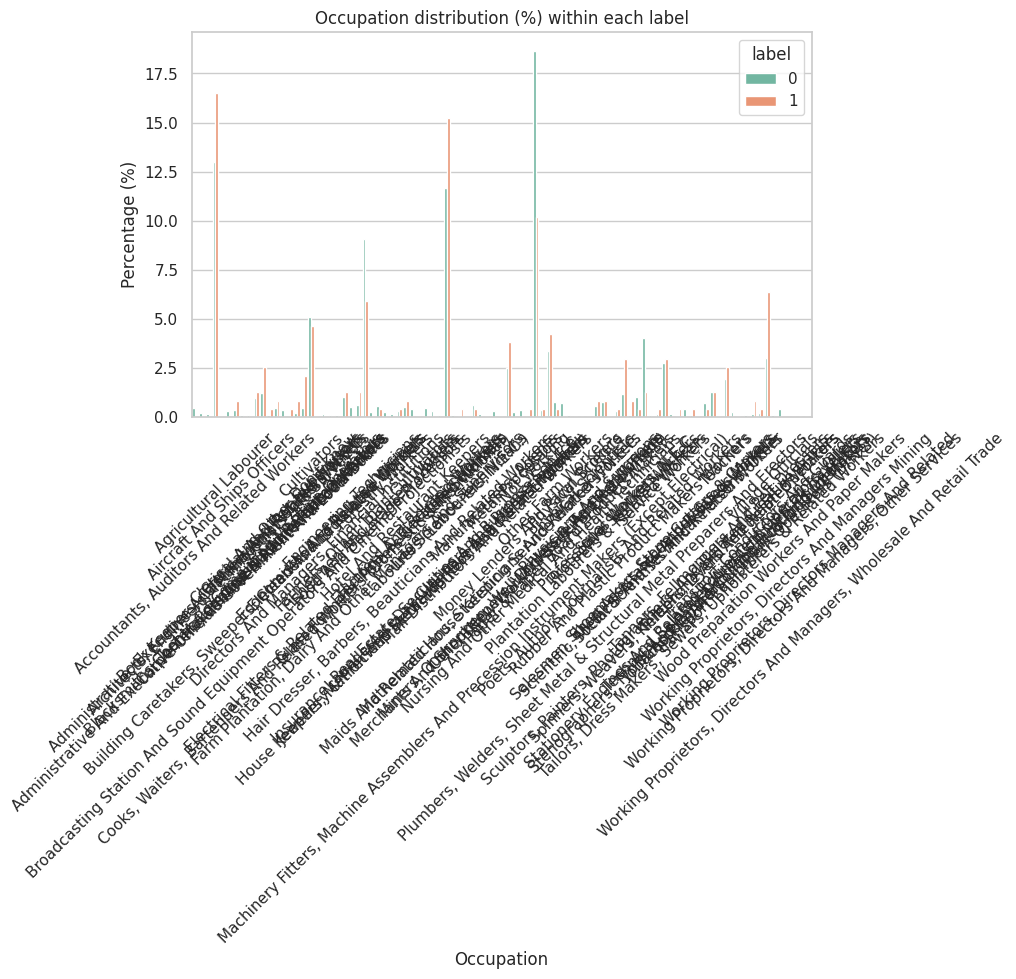

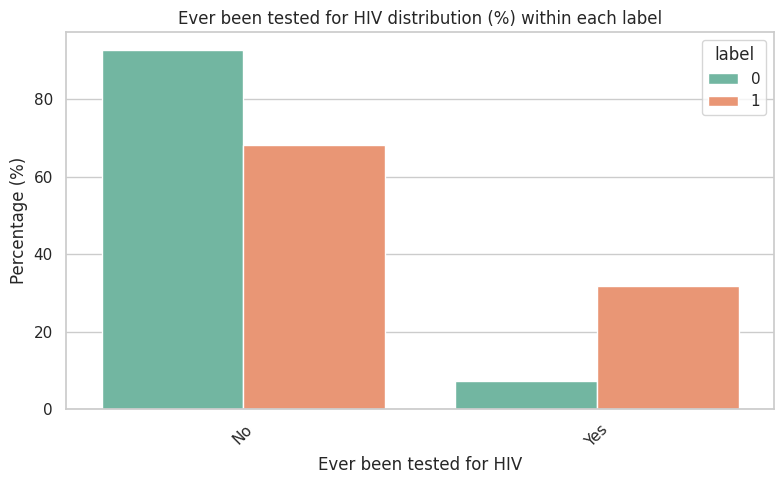

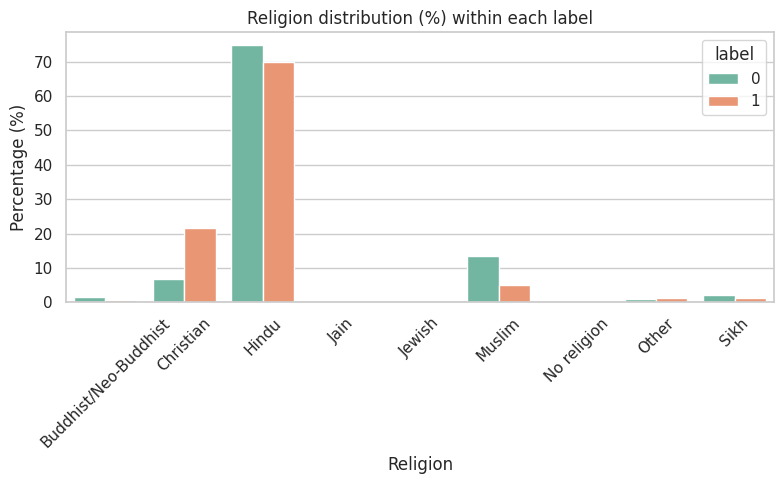

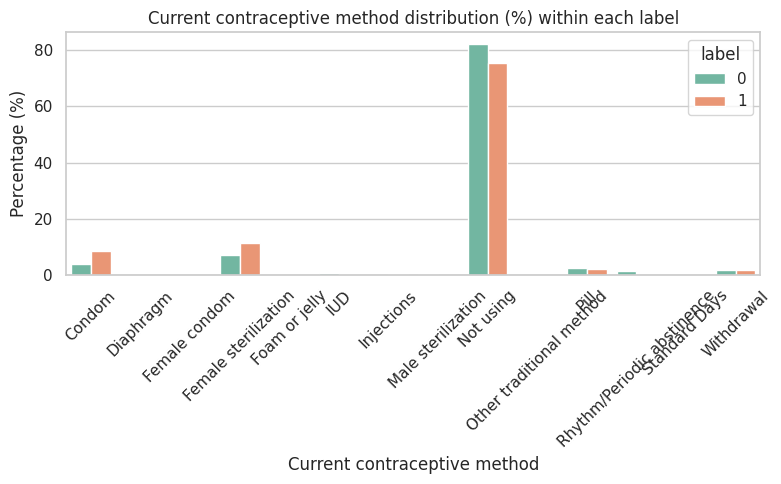

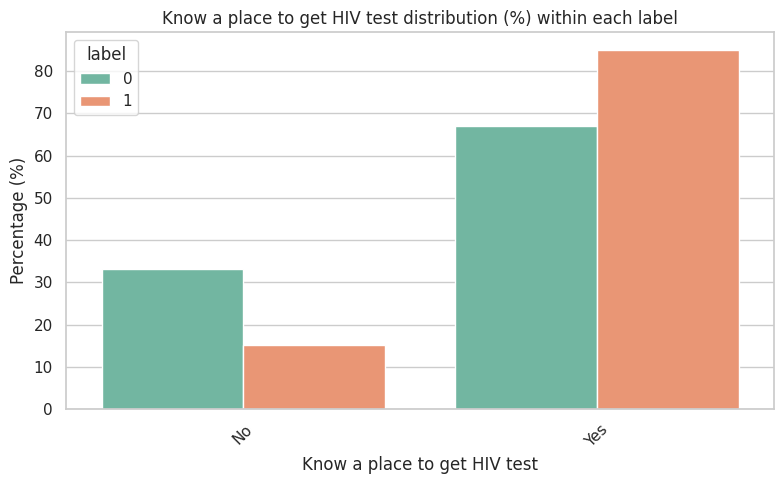

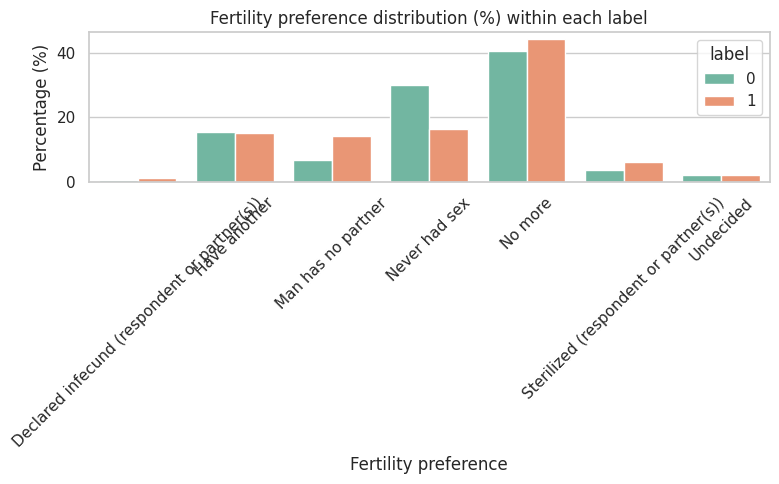

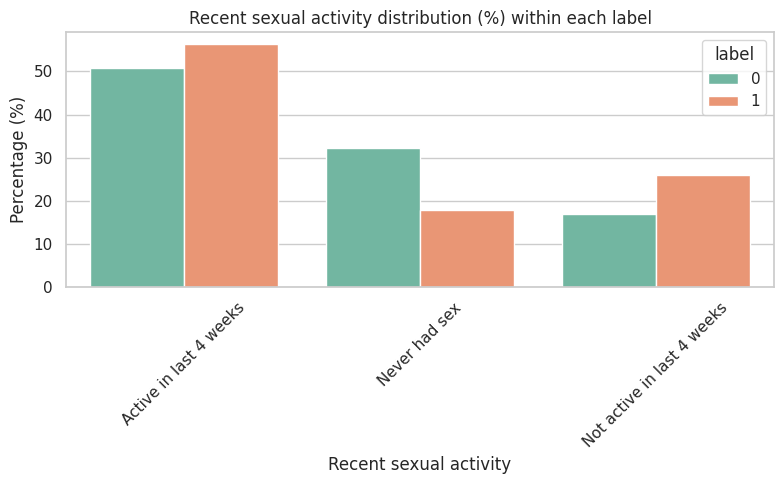

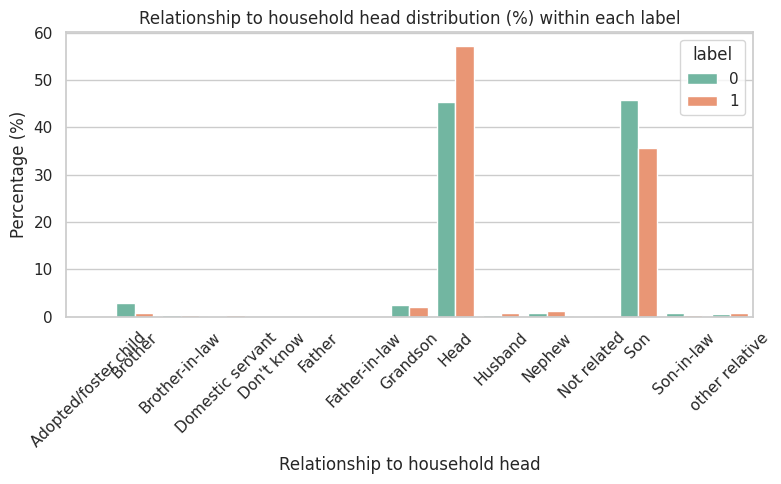

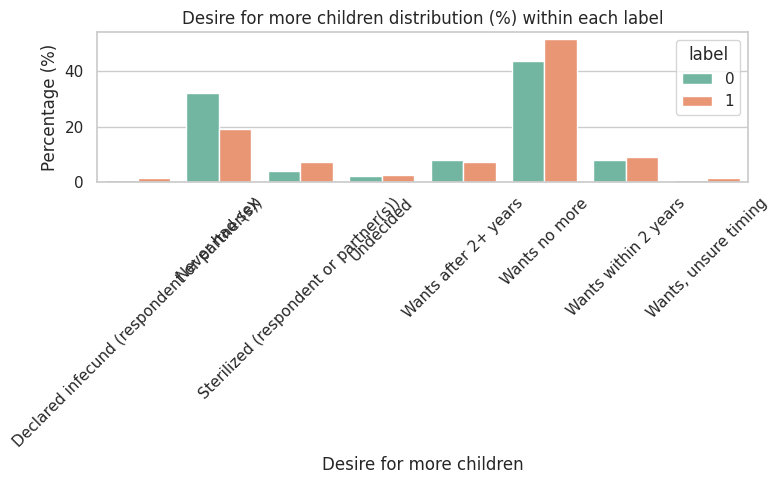

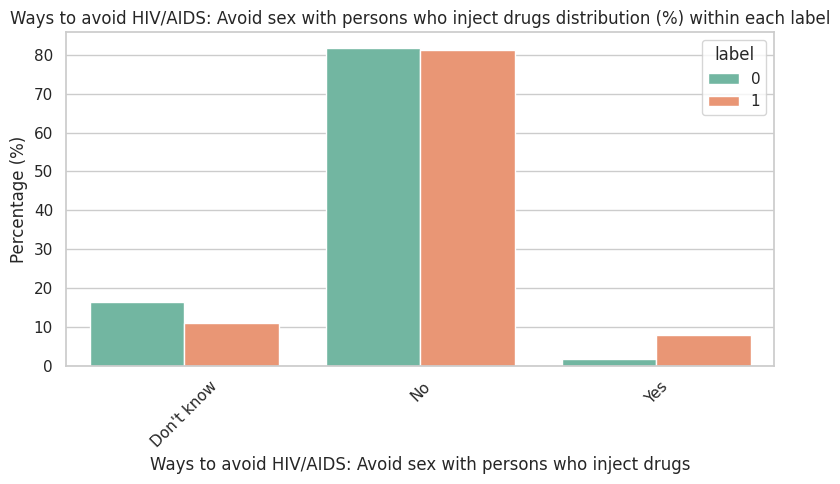

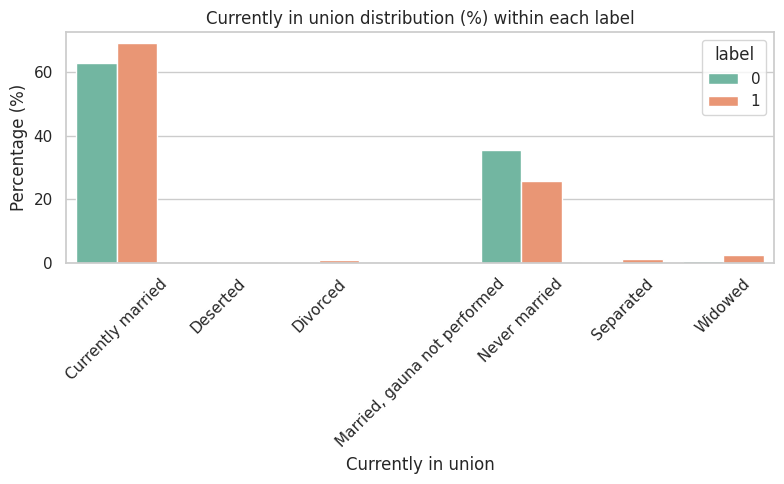

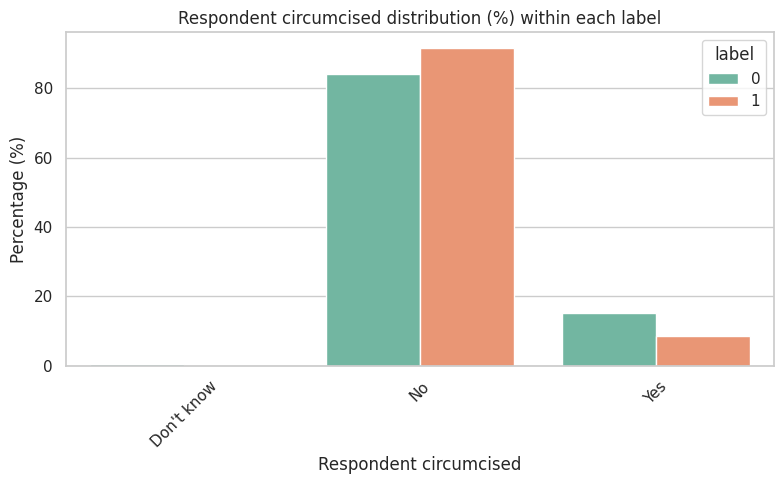

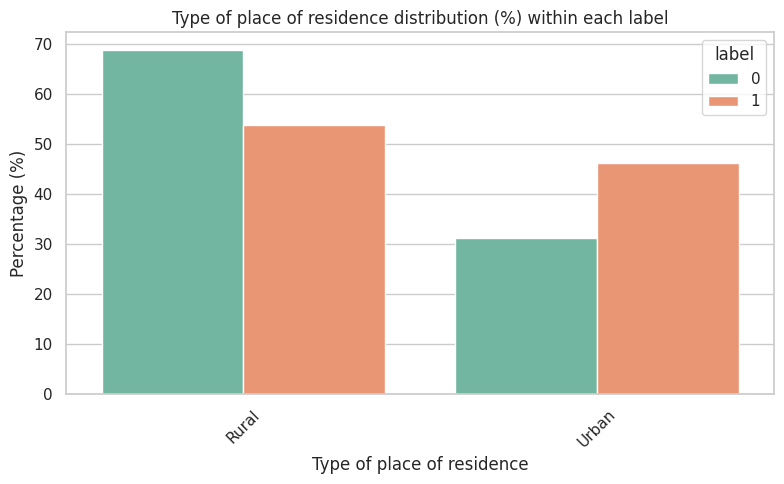

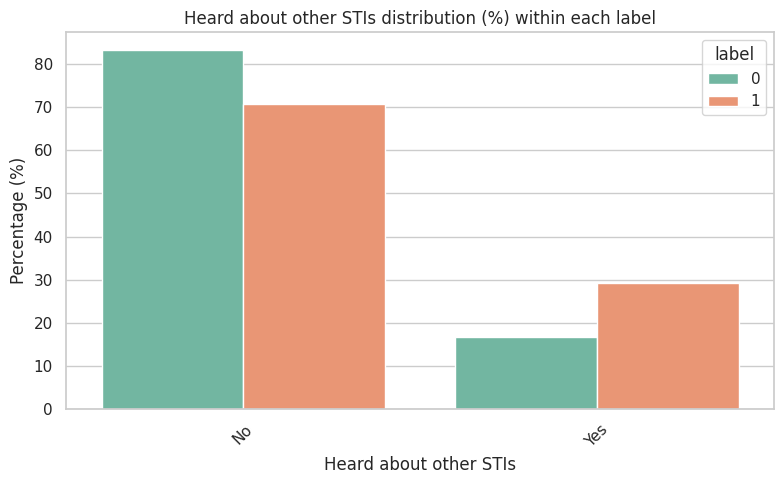

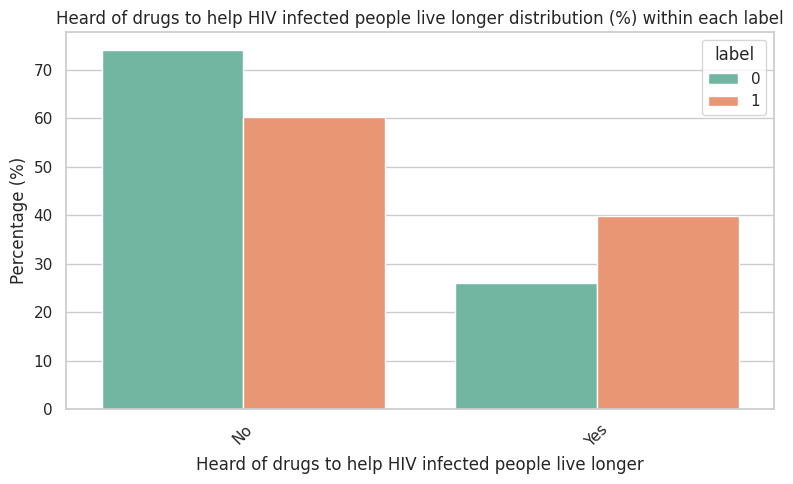

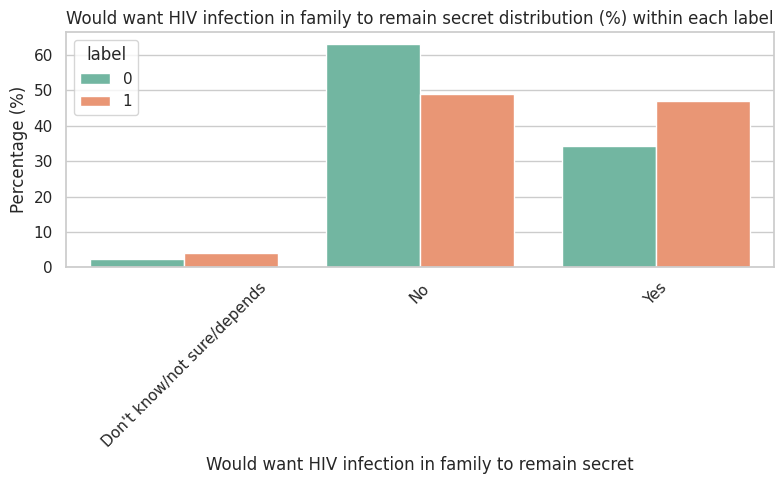

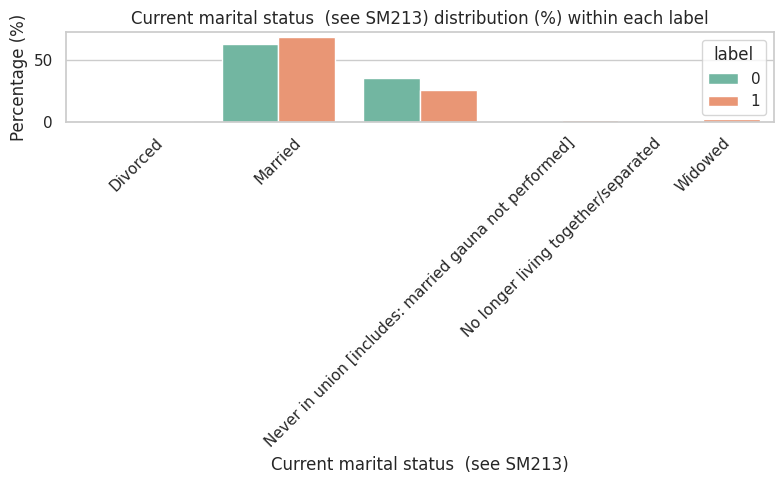

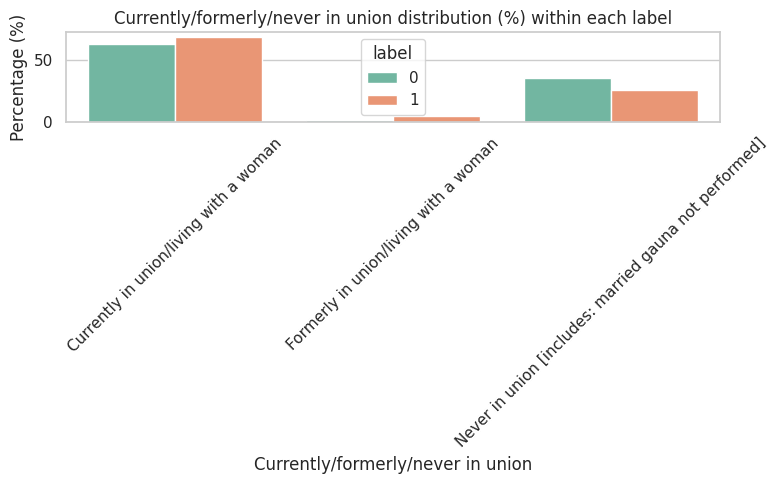

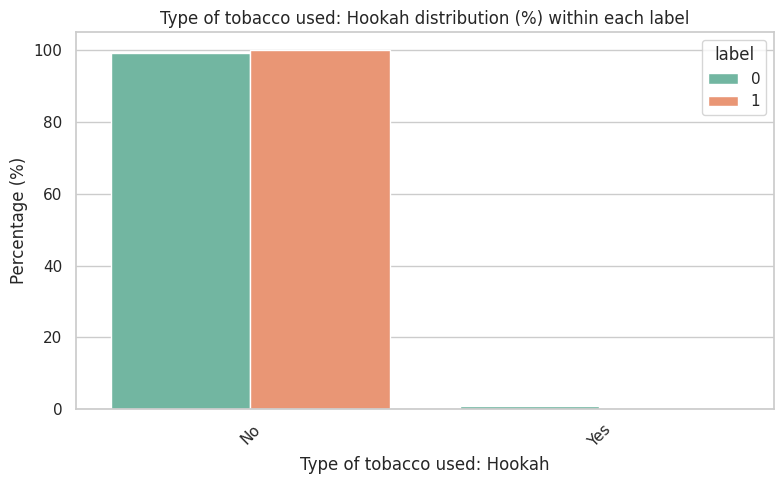

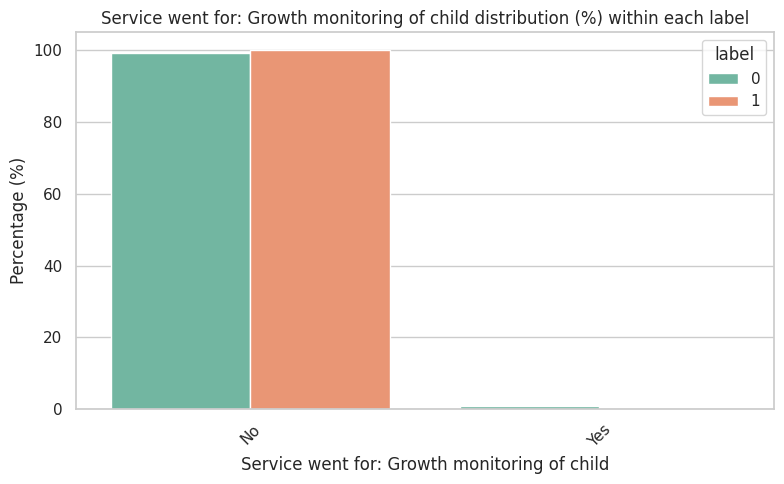

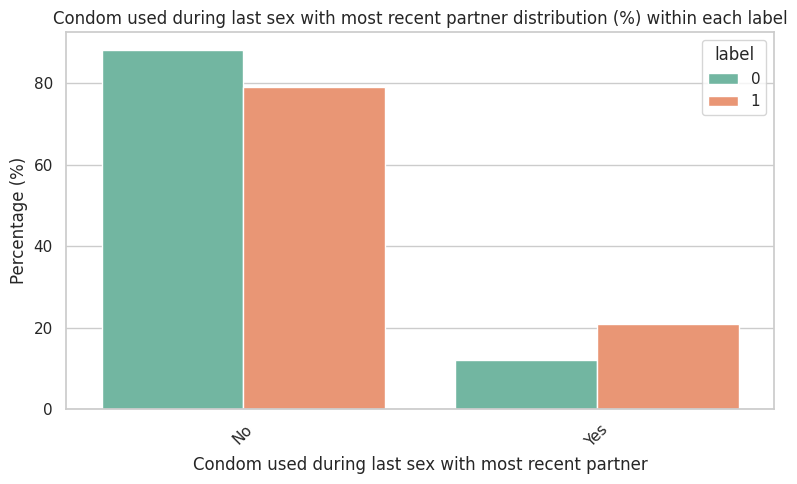

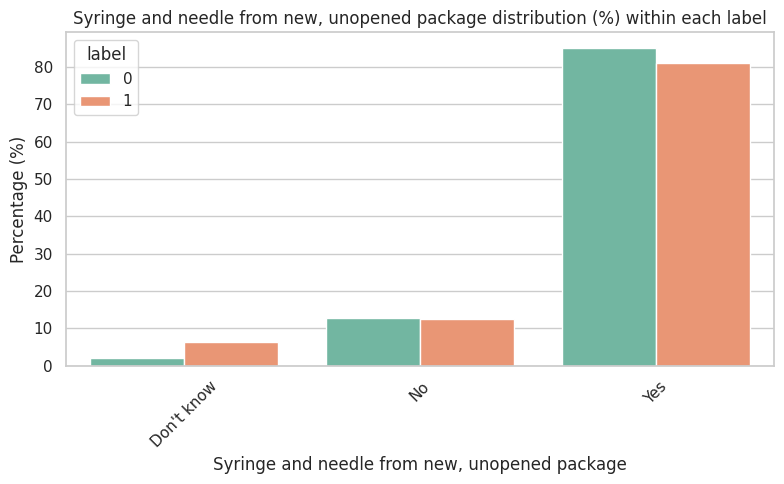

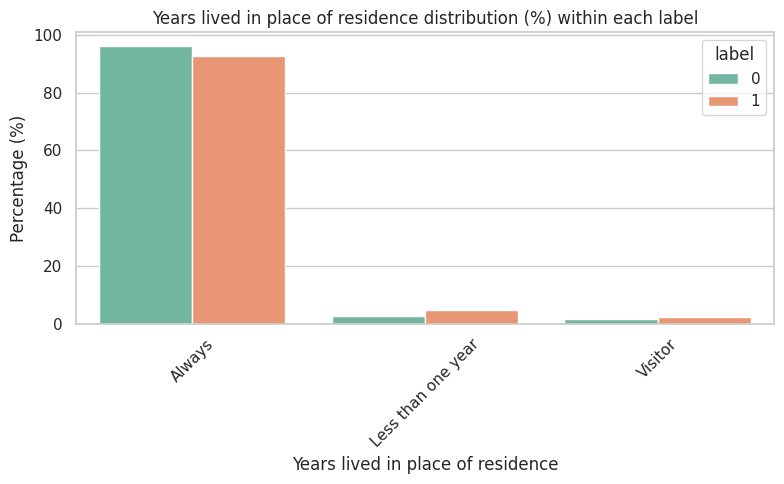

In [75]:
barplots_by_label(df_eda, 'label')

In [76]:
def barplots_by_target(df, target):
    cat_features = df.select_dtypes(include=['object', 'bool']).columns

    for feature in cat_features:
        if feature == target:
            continue
        # Count occurrences for each (label, feature category)
        counts = df.copy()
        counts[target] = counts[target].fillna("Missing").astype(str)
        counts = counts.groupby([target, feature], dropna=False).size().reset_index(name='count')
        # Plot
        plt.figure(figsize=(8, 5))
        sns.barplot(data=counts, x=feature, y='count', hue=target, palette='Set2')

        plt.title(f'{feature} distribution within each {target}')
        plt.ylabel('Count')
        plt.xlabel(feature)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [77]:
df_eda[(df_eda['Ever been tested for HIV'] == 'N') & (df_eda['Know a place to get HIV test'].isna())].shape

(0, 27)

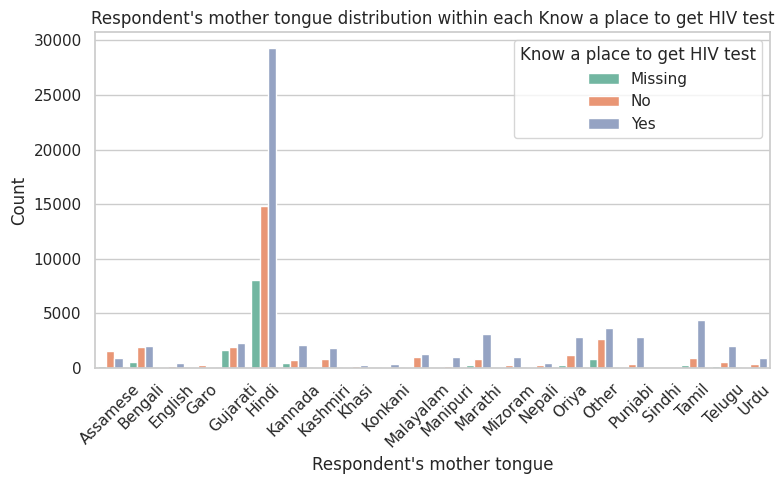

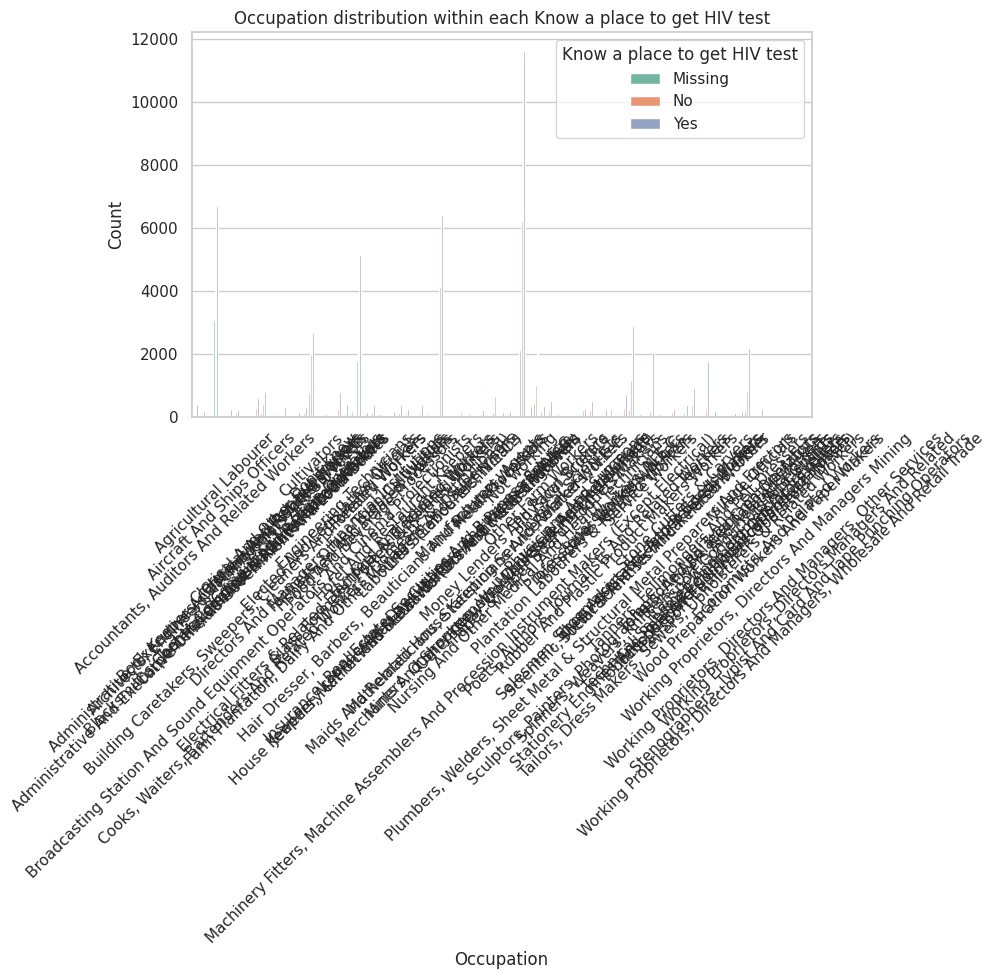

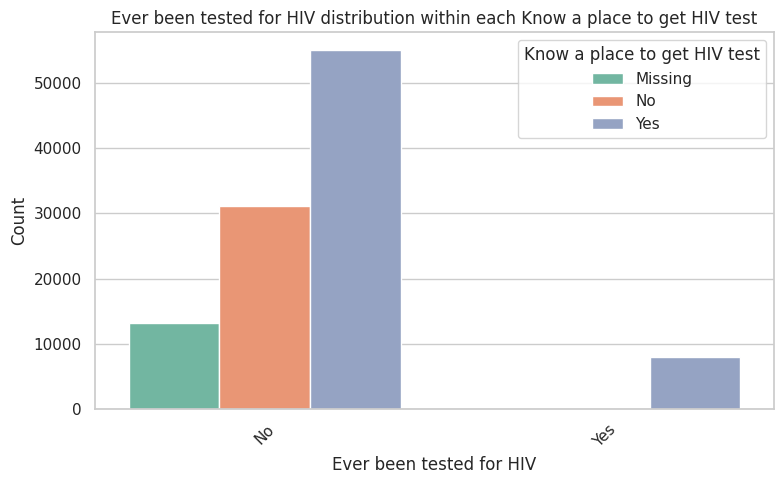

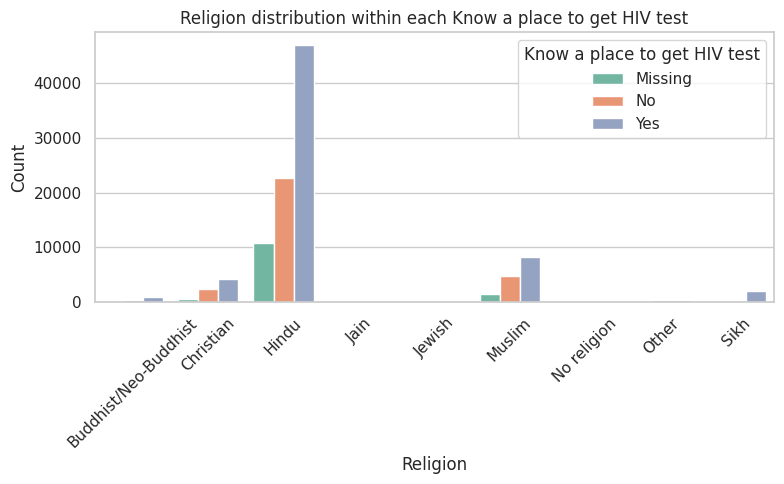

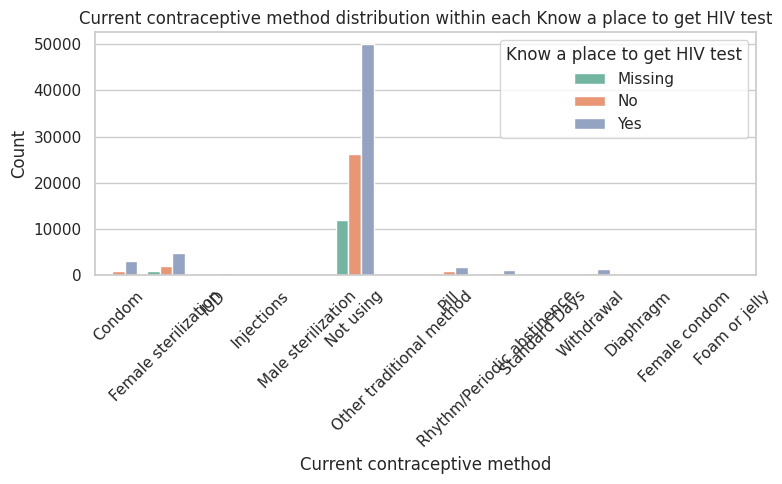

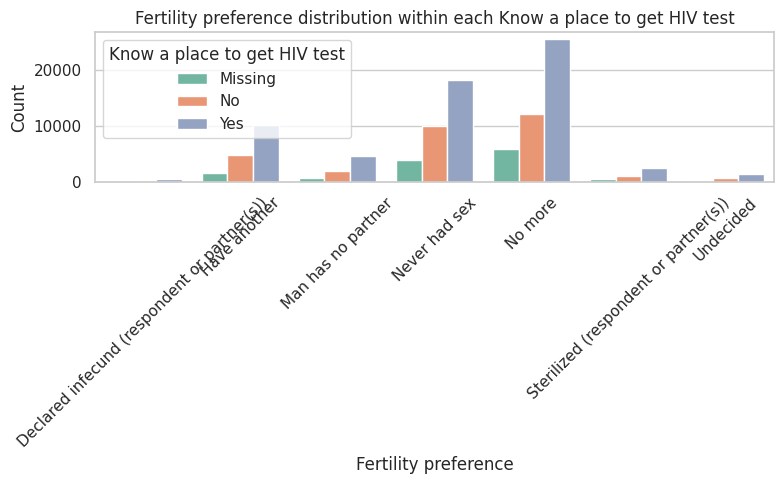

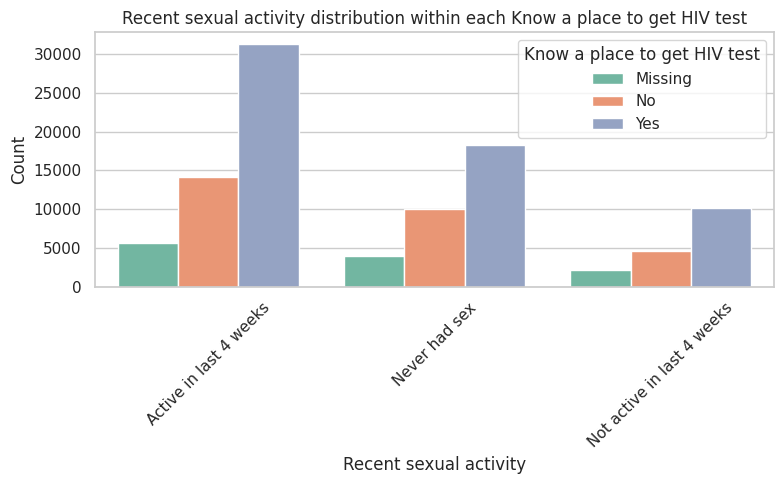

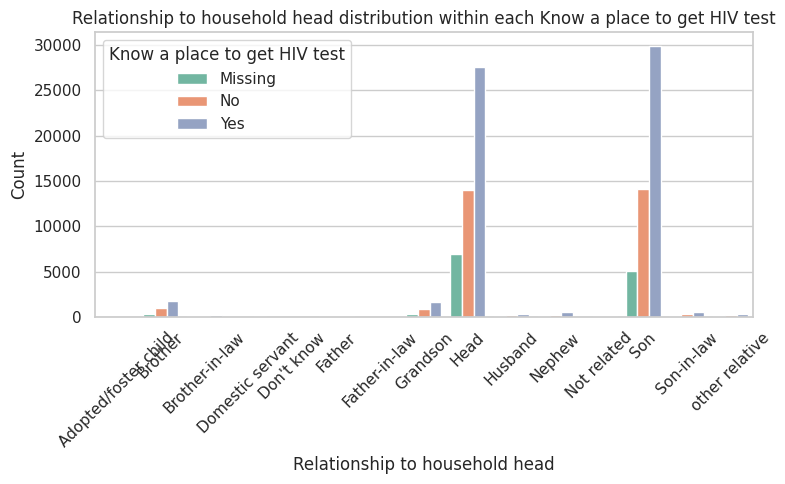

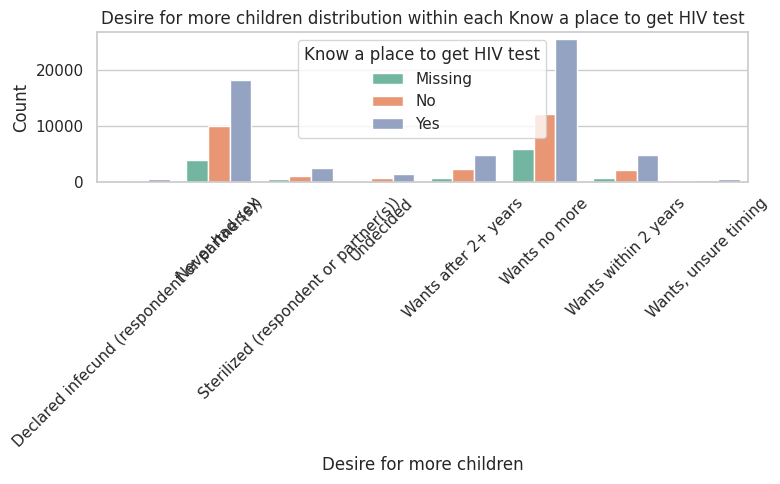

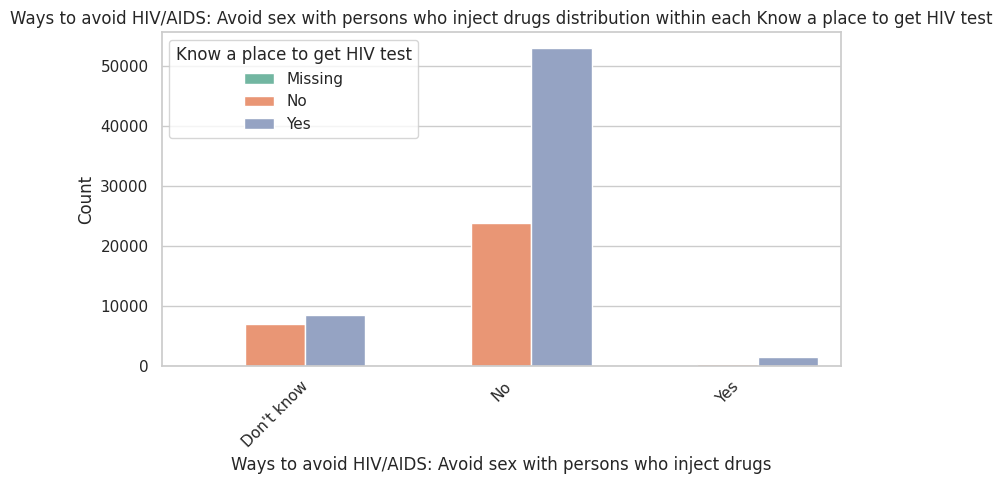

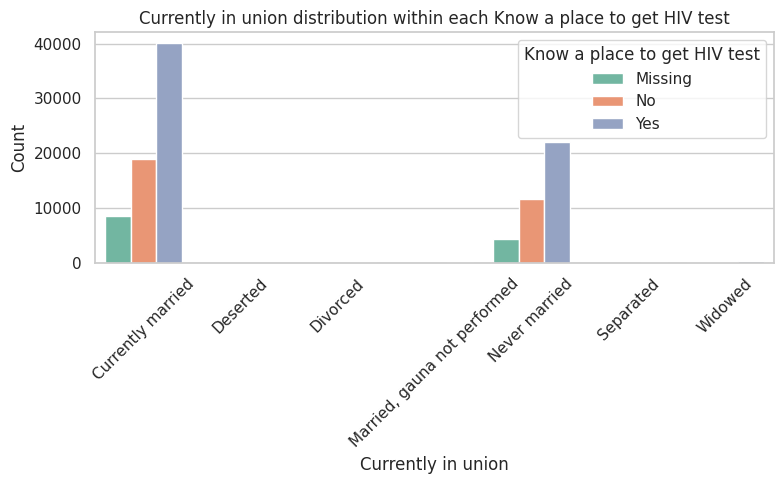

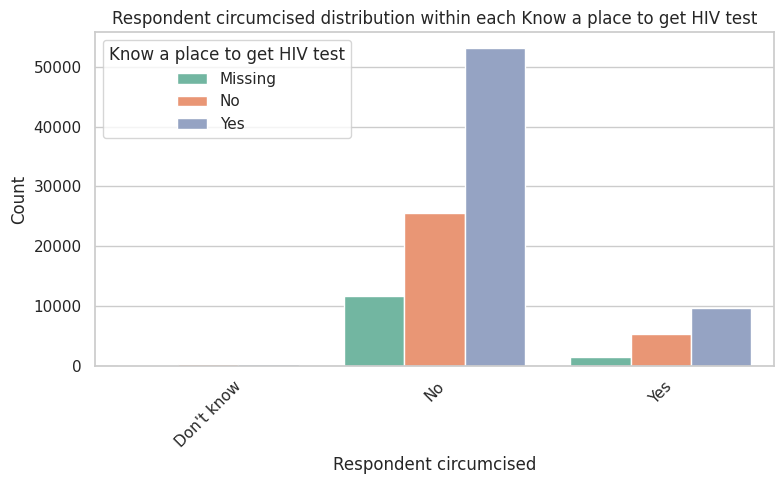

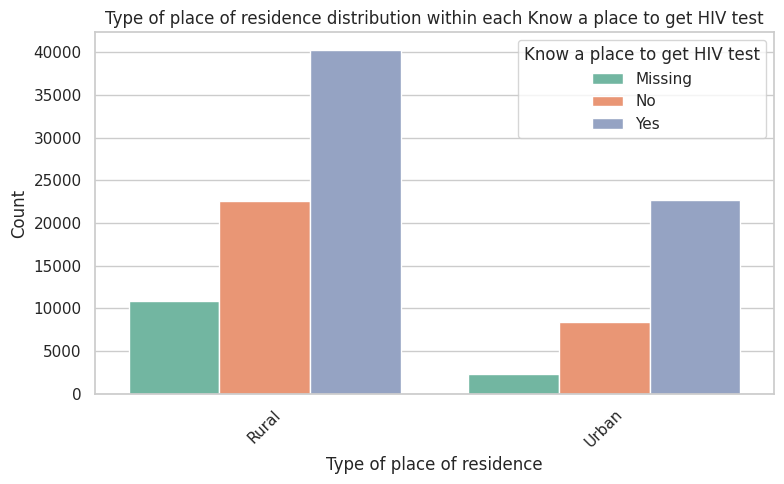

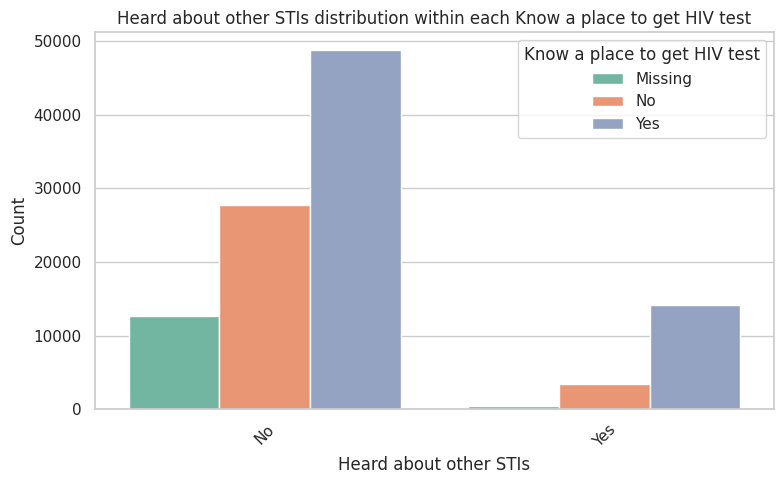

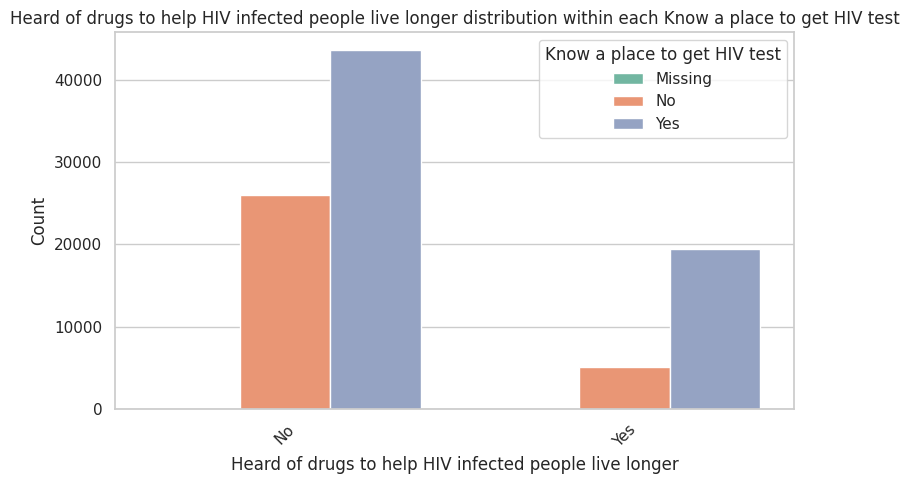

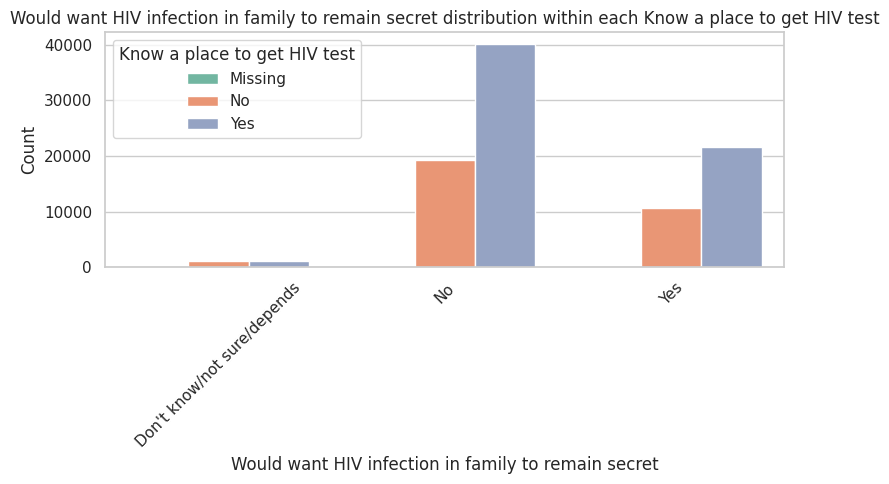

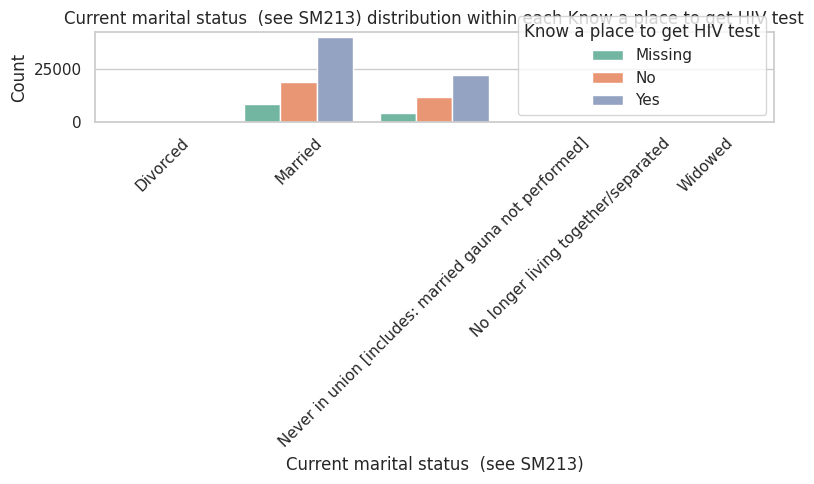

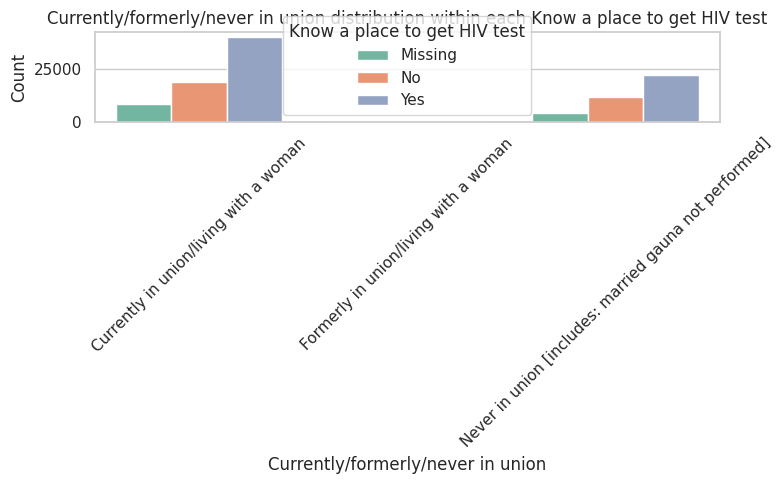

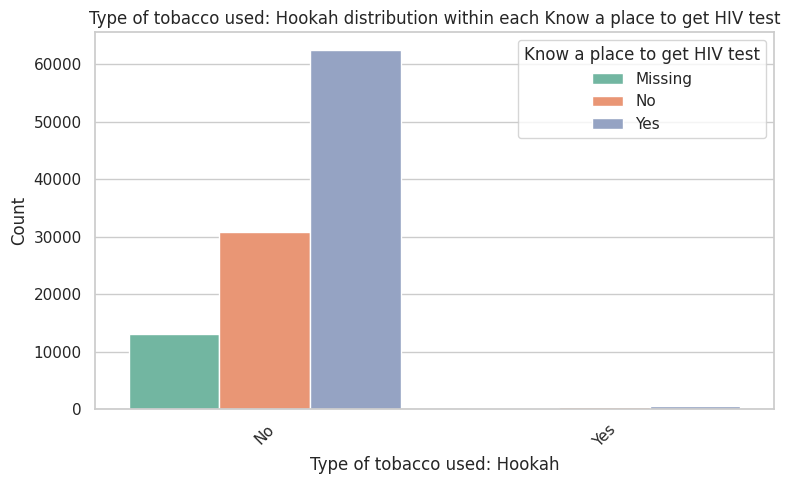

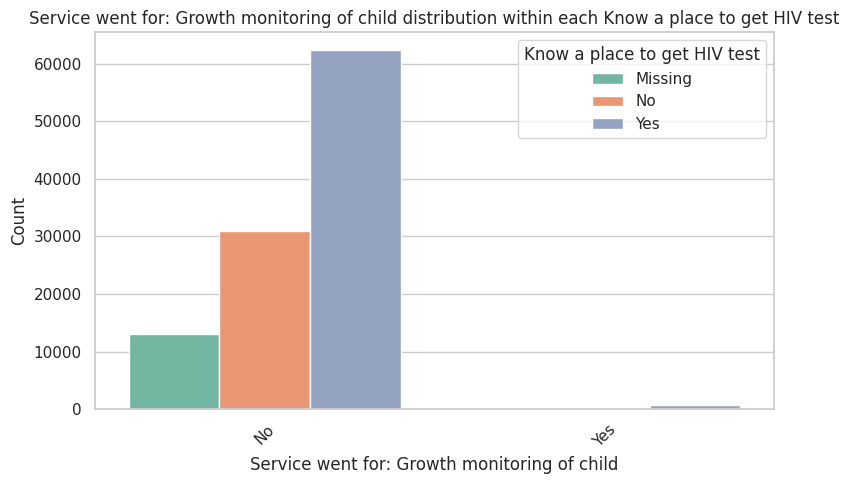

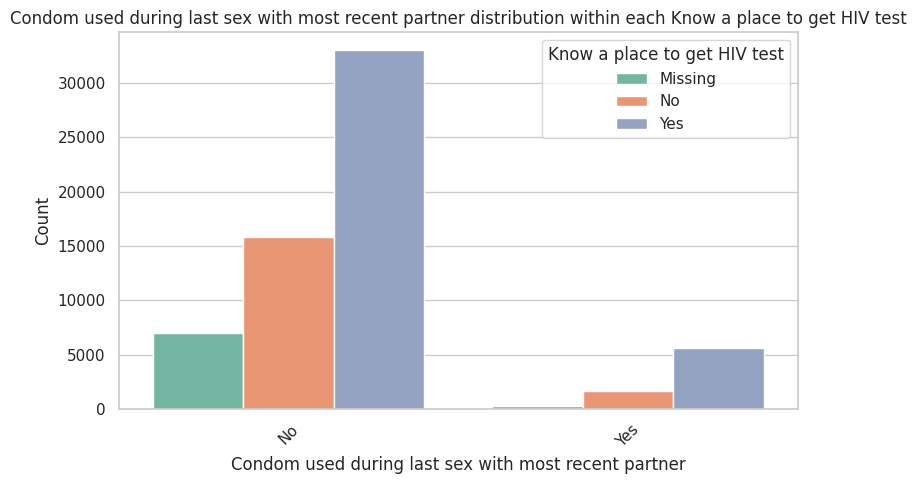

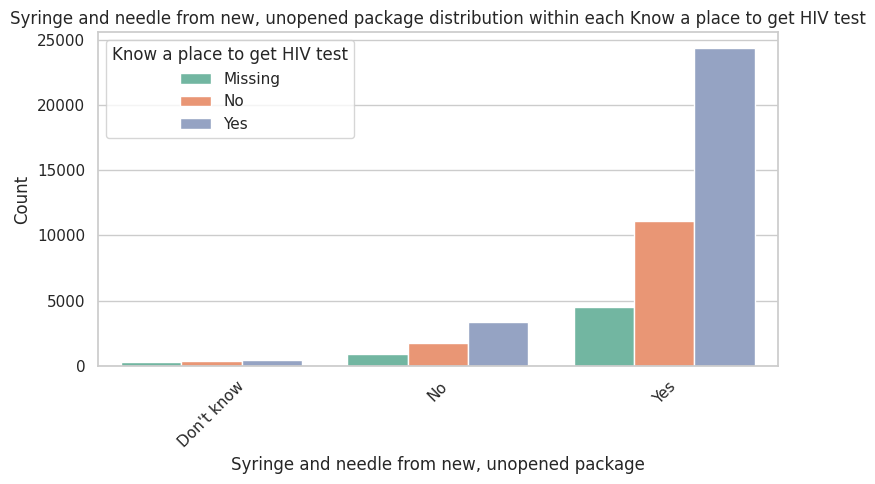

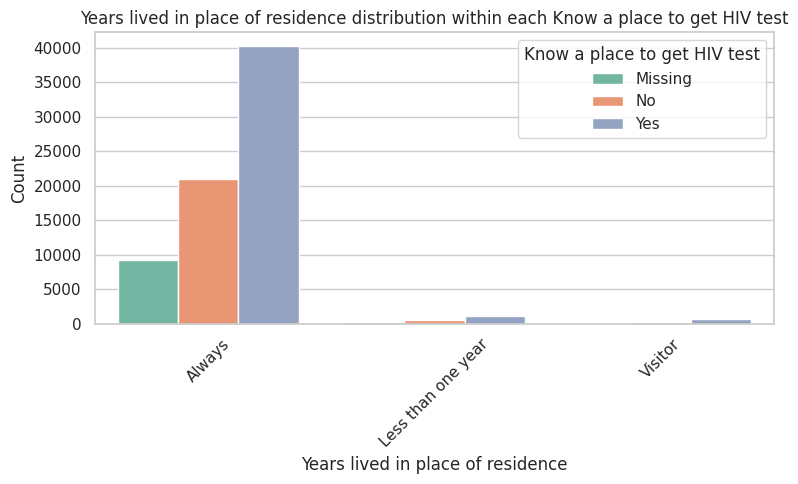

In [78]:
barplots_by_target(df_eda, 'Know a place to get HIV test')

## 2.2.6 Final Preprocessing

In [79]:
df_prep = df_eda.copy(deep=True)
df_prep.describe()

Current age  Number of living children
count  107294.000000              107294.000000
mean       31.761496                   1.476858
std        11.083551                   1.717349
min        15.000000                   0.000000
25%        22.000000                   0.000000
50%        30.000000                   1.000000
75%        40.000000                   2.000000
max        54.000000                  45.000000

In [80]:
df_prep['Know a place to get HIV test'].value_counts(dropna=False)

Know a place to get HIV test
Yes    62984
No     31098
NaN    13212
Name: count, dtype: int64

In [81]:
df_prep.isna().sum()

label                                                                  0
Respondent's mother tongue                                             1
Occupation                                                             0
Ever been tested for HIV                                               0
Religion                                                               0
Current contraceptive method                                           0
Current age                                                            0
Know a place to get HIV test                                       13212
Fertility preference                                                  79
Recent sexual activity                                              6993
Relationship to household head                                         0
Desire for more children                                            7597
Ways to avoid HIV/AIDS: Avoid sex with persons who inject drugs    13212
Currently in union                                                     0
Respondent circumcised                                                 1
Type of place of residence                                             0
Number of living children                                              0
Heard about other STIs                                                 1
Heard of drugs to help HIV infected people live longer             13212
Would want HIV infection in family to remain secret                13212
Current marital status  (see SM213)                                    0
Currently/formerly/never in union                                      0
Type of tobacco used: Hookah                                           0
Service went for: Growth monitoring of child                           0
Condom used during last sex with most recent partner               43901
Syringe and needle from new, unopened package                      60369
Years lived in place of residence                                  33946
dtype: int64

In [82]:
# num_cols = [c for c in df_prep.columns if df_prep[c].dtype == 'int64' or df_prep[c].dtype == 'float64']
# cat_cols = [c for c in df_prep.columns if df_prep[c].dtype in ['object'] and c != 'label']

# for c in num_cols:
#   df_prep[c].fillna(df_prep[c].mean(), inplace=True)
# for c in cat_cols:
#   df_prep[c].fillna(df_prep[c].mode()[0], inplace=True)
#   # df_prep[c].fillna('Missing')

In [83]:
cond1 = df_prep.isna().any(axis=1)
cond2 = df_prep['label'] == 1

df_prep = df_prep[(~cond1) | (cond2)]

In [84]:
df_prep.columns

Index(['label', 'Respondent's mother tongue', 'Occupation',
       'Ever been tested for HIV', 'Religion', 'Current contraceptive method',
       'Current age', 'Know a place to get HIV test', 'Fertility preference',
       'Recent sexual activity', 'Relationship to household head',
       'Desire for more children',
       'Ways to avoid HIV/AIDS: Avoid sex with persons who inject drugs',
       'Currently in union', 'Respondent circumcised',
       'Type of place of residence', 'Number of living children',
       'Heard about other STIs',
       'Heard of drugs to help HIV infected people live longer',
       'Would want HIV infection in family to remain secret',
       'Current marital status  (see SM213)',
       'Currently/formerly/never in union', 'Type of tobacco used: Hookah',
       'Service went for: Growth monitoring of child',
       'Condom used during last sex with most recent partner',
       'Syringe and needle from new, unopened package',
       'Years lived in place o

In [85]:
df_prep.head()

label Respondent's mother tongue                     Occupation  \
28     0                     Telugu  Fishermen And Related Workers   
46     0                      Hindi                    Cultivators   
53     0                      Hindi                    Cultivators   
59     0                      Hindi                    Cultivators   
64     0                      Hindi                    Cultivators   

   Ever been tested for HIV   Religion Current contraceptive method  \
28                       No      Hindu                       Condom   
46                      Yes  Christian                    Not using   
53                       No  Christian                    Not using   
59                      Yes     Muslim                    Not using   
64                      Yes  Christian                    Not using   

    Current age Know a place to get HIV test Fertility preference  \
28           38                          Yes              No more   
46           45                          Yes              No more   
53           37                          Yes            Undecided   
59           40                          Yes              No more   
64           48                          Yes              No more   

    Recent sexual activity  ... Heard about other STIs  \
28  Active in last 4 weeks  ...                     No   
46  Active in last 4 weeks  ...                     No   
53  Active in last 4 weeks  ...                     No   
59  Active in last 4 weeks  ...                     No   
64  Active in last 4 weeks  ...                     No   

   Heard of drugs to help HIV infected people live longer  \
28                                                Yes       
46                                                 No       
53                                                 No       
59                                                 No       
64                                                 No       

   Would want HIV infection in family to remain secret  \
28                                                Yes    
46                                                 No    
53                                                 No    
59                                                 No    
64                                                 No    

   Current marital status  (see SM213)  \
28                             Married   
46                             Married   
53                             Married   
59                             Married   
64                             Married   

         Currently/formerly/never in union Type of tobacco used: Hookah  \
28  Currently in union/living with a woman                           No   
46  Currently in union/living with a woman                           No   
53  Currently in union/living with a woman                           No   
59  Currently in union/living with a woman                           No   
64  Currently in union/living with a woman                           No   

    Service went for: Growth monitoring of child  \
28                                            No   
46                                            No   
53                                            No   
59                                            No   
64                                            No   

   Condom used during last sex with most recent partner  \
28                                                Yes     
46                                                 No     
53                                                 No     
59                                                 No     
64                                                 No     

   Syringe and needle from new, unopened package  \
28                                           Yes   
46                                           Yes   
53                                           Yes   
59                                           Yes   
64                                         

### Feature Engineering

In [86]:
yes_no_cols = [
    'Ever been tested for HIV', 'Know a place to get HIV test',
    'Would want HIV infection in family to remain secret',
    'Respondent circumcised',
    'Ways to avoid HIV/AIDS: Avoid sex with persons who inject drugs',
    'Service went for: Growth monitoring of child',
    'Syringe and needle from new, unopened package',
    'Condom used during last sex with most recent partner'
]

# Map common responses
def clean_binary(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: {'Yes': 1, 'No': 0}.get(x, -1))
    return df
df_prep[yes_no_cols] = clean_binary(df_prep[yes_no_cols],yes_no_cols )

In [87]:
prevention_cols = [
    'Know a place to get HIV test',
    'Ever been tested for HIV',
    'Ways to avoid HIV/AIDS: Avoid sex with persons who inject drugs',
    'Condom used during last sex with most recent partner',
    'Syringe and needle from new, unopened package'
]
df_prep['prevention_score'] = df_prep[prevention_cols].replace(-1, 0).sum(axis=1)


In [88]:
# Age bucket × HIV tested
df_prep['age_group'] = pd.cut(df_prep['Current age'], bins=[0, 20, 30, 40, 60, 100], labels=['<20', '20-30', '30-40', '40-60', '60+'])
df_prep['tested_age_group'] = df_prep['age_group'].astype(str) + '_' + df_prep['Ever been tested for HIV'].astype(str)

# Religion × Stigma attitude
df_prep['religion_stigma'] = df_prep['Religion'].astype(str) + '_' + df_prep['Would want HIV infection in family to remain secret'].astype(str)

# Contraceptive × Fertility preference
df_prep['fertility_plan'] = df_prep['Current contraceptive method'].astype(str) + '_' + df_prep['Fertility preference'].astype(str)


In [89]:
for col in ['Occupation', 'Religion', "Respondent's mother tongue"]:
    freq_map = df_prep[col].value_counts(normalize=True)
    df_prep[f'{col}_freq'] = df_prep[col].map(freq_map)


In [90]:
df_prep['isHindu'] = np.where(df_prep['Religion'] == 'Hindu', 1, 0)
df_prep["speakHindi"] = np.where(df_prep["Respondent's mother tongue"] == "Hindi", 1, 0)

In [91]:
df_prep.head()

label Respondent's mother tongue                     Occupation  \
28     0                     Telugu  Fishermen And Related Workers   
46     0                      Hindi                    Cultivators   
53     0                      Hindi                    Cultivators   
59     0                      Hindi                    Cultivators   
64     0                      Hindi                    Cultivators   

    Ever been tested for HIV   Religion Current contraceptive method  \
28                         0      Hindu                       Condom   
46                         1  Christian                    Not using   
53                         0  Christian                    Not using   
59                         1     Muslim                    Not using   
64                         1  Christian                    Not using   

    Current age  Know a place to get HIV test Fertility preference  \
28           38                             1              No more   
46           45                             1              No more   
53           37                             1            Undecided   
59           40                             1              No more   
64           48                             1              No more   

    Recent sexual activity  ... prevention_score age_group  tested_age_group  \
28  Active in last 4 weeks  ...                3     30-40           30-40_0   
46  Active in last 4 weeks  ...                3     40-60           40-60_1   
53  Active in last 4 weeks  ...                2     30-40           30-40_0   
59  Active in last 4 weeks  ...                3     30-40           30-40_1   
64  Active in last 4 weeks  ...                3     40-60           40-60_1   

   religion_stigma       fertility_plan Occupation_freq  Religion_freq  \
28         Hindu_1       Condom_No more        0.003248       0.782803   
46     Christian_0    Not using_No more        0.059873       0.026815   
53     Christian_0  Not using_Undecided        0.059873       0.026815   
59        Muslim_0    Not using_No more        0.059873       0.134522   
64     Christian_0    Not using_No more        0.059873       0.026815   

   Respondent's mother tongue_freq isHindu  speakHindi  
28                        0.027898       1           0  
46                        0.572739       0           1  
53                        0.572739       0           1  
59                        0.572739       0           1  
64                        0.572739       0           1  

[5 rows x 37 columns]

In [92]:
df_prep.shape

(15700, 37)

## Splitting client

In [93]:
SAMPLE_SIZE = len(df_prep)
df_pos = df_prep[df_prep['label'] == 1]
df_neg = df_prep[df_prep['label'] == 0]
col_model = df_prep.columns.tolist()
col_model.remove('label')
df_model = pd.concat([df_pos, df_neg.sample(SAMPLE_SIZE - len(df_pos), random_state=38)])
df_model.shape

(15700, 37)

In [94]:
# Divide clients with different rates
X = df_model[col_model]
y = df_model['label']

X_pos = X[y == 1]
X_neg = X[y == 0]
y_pos = y[y == 1]
y_neg = y[y == 0]

rate = [.1,.11,.25,.06,.04,.15,.07,.13,.05,.04]
divide = []
cum_neg, cum_pos = 0, 0
client_data0 = []
client_labels0 = []

for i in range(len(rate)):
  start_neg = cum_neg
  end_neg = start_neg + int(len(X_neg) * rate[i])
  start_pos = cum_pos
  end_pos = start_pos + int(len(X_pos) * rate[i])
  cum_neg = end_neg
  cum_pos = end_pos
  client_data0.append(X_neg[start_neg:end_neg])
  client_data0[-1] = pd.concat([client_data0[-1], X_pos[start_pos:end_pos]], axis=0)
  client_labels0.append(y_neg[start_neg:end_neg])
  client_labels0[-1] = pd.concat([client_labels0[-1], y_pos[start_pos:end_pos]], axis=0)
  print(f'Client {i + 1} got:')
  print(f'Negative: [{start_neg},{end_neg}), Total: {end_neg - start_neg}, Rate(of all dataset): {(end_neg - start_neg) / len(X_neg)}')
  print(f'Positive: [{start_pos},{end_pos}), Total: {end_pos - start_pos}, Rate(of all positive case): {(end_pos - start_pos) / len(X_pos)}')
  print('-' * 20)



Client 1 got:
Negative: [0,1546), Total: 1546, Rate(of all dataset): 0.09997413347128815
Positive: [0,23), Total: 23, Rate(of all positive case): 0.09745762711864407
--------------------
Client 2 got:
Negative: [1546,3247), Total: 1701, Rate(of all dataset): 0.10999741334712881
Positive: [23,48), Total: 25, Rate(of all positive case): 0.1059322033898305
--------------------
Client 3 got:
Negative: [3247,7113), Total: 3866, Rate(of all dataset): 0.25
Positive: [48,107), Total: 59, Rate(of all positive case): 0.25
--------------------
Client 4 got:
Negative: [7113,8040), Total: 927, Rate(of all dataset): 0.05994568028970512
Positive: [107,121), Total: 14, Rate(of all positive case): 0.059322033898305086
--------------------
Client 5 got:
Negative: [8040,8658), Total: 618, Rate(of all dataset): 0.03996378685980342
Positive: [121,130), Total: 9, Rate(of all positive case): 0.038135593220338986
--------------------
Client 6 got:
Negative: [8658,10977), Total: 2319, Rate(of all dataset): 0.1

## Sampling strategies

In [96]:
class Upsampler:
    def __init__(self, strategy='none', sampling_strategy=1.0):
        """
        strategy: upsampling method name
        sampling_strategy: float, dict, str or callable
            - float: proportion of minority to majority after resample
            - 1.0 means perfectly balanced
        """
        self.strategy = strategy
        self.sampling_strategy = sampling_strategy
        self.resampler = None

        if strategy == 'smote':
            from imblearn.over_sampling import SMOTE
            self.resampler = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
        elif strategy == 'blsmote':
            from imblearn.over_sampling import BorderlineSMOTE
            self.resampler = BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=42)
        elif strategy == 'duplicate':
            from imblearn.over_sampling import RandomOverSampler
            self.resampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
        elif strategy == 'adasyn':
            from imblearn.over_sampling import ADASYN
            self.resampler = ADASYN(sampling_strategy=sampling_strategy, random_state=42)
        elif strategy == 'svmsmote':
            from imblearn.over_sampling import SVMSMOTE
            self.resampler = SVMSMOTE(sampling_strategy=sampling_strategy, random_state=42)
        elif strategy == 'smotetomek':
            from imblearn.combine import SMOTETomek
            self.resampler = SMOTETomek(sampling_strategy=sampling_strategy, random_state=42)
        elif strategy == 'none':
            self.resampler = None
        else:
            raise ValueError(f"Unknown upsampling strategy: {strategy}")

    def fit_resample(self, X, y):
        if self.resampler is not None:
            return self.resampler.fit_resample(X, y)
        else:
            return X, y


class Downsampler:
    def __init__(self, strategy='none', sampling_strategy='auto'):
        """
        strategy: downsampling method name
        sampling_strategy:
            - float: proportion of minority to majority after resample
            - 'auto': automatically balance by removing samples from majority class
        """
        self.strategy = strategy
        self.sampling_strategy = sampling_strategy
        self.resampler = None

        if strategy == 'random':
            from imblearn.under_sampling import RandomUnderSampler
            self.resampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
        elif strategy == 'cluster_centroids':
            from imblearn.under_sampling import ClusterCentroids
            self.resampler = ClusterCentroids(sampling_strategy=sampling_strategy, random_state=42)
        elif strategy == 'condensed_nn':
            from imblearn.under_sampling import CondensedNearestNeighbour
            self.resampler = CondensedNearestNeighbour(sampling_strategy=sampling_strategy, random_state=42)
        elif strategy == 'repeated_enn':
            from imblearn.under_sampling import RepeatedEditedNearestNeighbours
            self.resampler = RepeatedEditedNearestNeighbours(sampling_strategy=sampling_strategy)
        elif strategy == 'allknn':
            from imblearn.under_sampling import AllKNN
            self.resampler = AllKNN(sampling_strategy=sampling_strategy)
        elif strategy == 'iht':
            from imblearn.under_sampling import InstanceHardnessThreshold
            from sklearn.ensemble import RandomForestClassifier
            self.resampler = InstanceHardnessThreshold(
                estimator=RandomForestClassifier(random_state=42),
                sampling_strategy=sampling_strategy
            )
        elif strategy == 'nearmiss':
            from imblearn.under_sampling import NearMiss
            self.resampler = NearMiss(sampling_strategy=sampling_strategy)
        elif strategy == 'ncr':
            from imblearn.under_sampling import NeighbourhoodCleaningRule
            self.resampler = NeighbourhoodCleaningRule(sampling_strategy=sampling_strategy)
        elif strategy == 'oss':
            from imblearn.under_sampling import OneSidedSelection
            self.resampler = OneSidedSelection(sampling_strategy=sampling_strategy, random_state=42)
        elif strategy == 'tomek':
            from imblearn.under_sampling import TomekLinks
            self.resampler = TomekLinks(sampling_strategy="auto")
        elif strategy == 'none':
            self.resampler = None
        else:
            raise ValueError(f"Unknown downsampling strategy: {strategy}")

    def fit_resample(self, X, y):
        if self.resampler is not None:
            return self.resampler.fit_resample(X, y)
        else:
            return X, y


def balanced_mixup(X, y, alpha=5):
  import numpy as np
  from sklearn.preprocessing import OneHotEncoder
  X_new, y_new = [], []
  class_indices = {cls: np.where(y == cls)[0] for cls in np.unique(y)}

  # Convert y to numpy array before reshaping
  y_array = y.to_numpy().reshape(-1, 1)
  onehot = OneHotEncoder(sparse_output=False).fit(y_array)
  y_oh = onehot.transform(y_array)

  for _ in range(len(X)):
      # 1. Sample (xi, yi) using class-frequency
      cls_i = np.random.choice(list(class_indices.keys()), p=[len(class_indices[c])/len(X) for c in class_indices])
      i = np.random.choice(class_indices[cls_i])

      # 2. Sample (xj, yj) uniformly across classes
      cls_j = np.random.choice(list(class_indices.keys()))
      j = np.random.choice(class_indices[cls_j])

      lam = np.random.beta(alpha, 1.0)
      x_mix = lam * X[i] + (1 - lam) * X[j]
      y_mix = lam * y_oh[i] + (1 - lam) * y_oh[j]

      X_new.append(x_mix)
      y_new.append(y_mix)

  return np.array(X_new), np.array(y_new)

def hybrid_sampling(X, y):
  from imblearn.combine import SMOTETomek
  strategy = 'minority'
  smt = SMOTETomek(random_state=42, sampling_strategy=strategy)
  X_res, y_res = smt.fit_resample(X, y)
  return X_res, y_res



# Compare diff client selection for RFFL

## Preprocess data

In [97]:
# ----- Preprocess train test -----
def fill_and_scale(X_train, X_test, y_train, y_test):
    numerical_cols = X_train.select_dtypes(include=['number']).columns
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    # Imputers
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')

    # Scaler
    scaler = StandardScaler()

    # Impute numeric columns
    X_train[numerical_cols] = imputer_num.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = imputer_num.transform(X_test[numerical_cols])

    # Fill missing for categoricals as string
    X_train[categorical_cols] = X_train[categorical_cols].astype(str).fillna("Missing")
    X_test[categorical_cols] = X_test[categorical_cols].astype(str).fillna("Missing")

    # Scale numeric columns
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    return X_train, X_test, y_train, y_test

def categoric_encode(X_train, X_test, y_train, y_test):
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    te = TargetEncoder(cols=categorical_cols)
    X_train[categorical_cols] = te.fit_transform(X_train[categorical_cols], y_train)
    X_test[categorical_cols] = te.transform(X_test[categorical_cols])

    return X_train, X_test, y_train, y_test

def build_RF_model(X, y, num_trees=100, upsample_strategy='', downsample_strategy='', upsample_threshold=1, downsample_threshold=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=38)
    X_train, X_test, y_train, y_test = fill_and_scale(X_train, X_test, y_train, y_test)
    X_train, X_test, y_train, y_test = categoric_encode(X_train, X_test, y_train, y_test)
    if upsample_strategy == 'smotetomek' or downsample_strategy == 'smotetomek':
      X_train, y_train = hybrid_sampling(X_train, y_train)
    else:
     # Downsampling first
      downsampler = Downsampler(strategy=downsample_strategy, sampling_strategy=downsample_threshold)
      X_train, y_train = downsampler.fit_resample(X_train, y_train)
      # Upsampling later
      upsampler = Upsampler(strategy=upsample_strategy, sampling_strategy=upsample_threshold)
      X_train, y_train = upsampler.fit_resample(X_train, y_train)

    client_train_labels.append(y_train)
    client_train_data.append(X_train)
    client_test_data.append(X_test)
    client_test_labels.append(y_test)
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=num_trees, random_state=42)
    rf.fit(X_train, y_train)
    # Predict on test set
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]

    # Evaluate
    metrics = {
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_proba)
    }

    # Store metrics
    client_metrics.append(metrics)

    return rf

# ----- Server Aggregation Function -----
def client_selection(number_client,strategy="random",
                    threshold=0.7,
                    metrics=None,
                    weights=None,
                    sample_size=None):
    total_clients = len(local_models)
    if strategy == "random":
        selected_indices = random.sample(range(total_clients), int(total_clients * threshold))

    elif strategy == "topk":
        if metrics is None:
            raise ValueError("Top-k strategy requires `metrics` list (e.g., F1 scores).")
        k = int(total_clients * threshold)
        def top_k_sampling(metric, k):
            return sorted(np.argsort(metric)[-k:].tolist())
        selected_indices = top_k_sampling([client_metrics[i]['auc'] for i in range(len(rate))], k)

    elif strategy == "weighted":
        if weights is None:
            raise ValueError("Weighted strategy requires `weights` list.")
        selected_indices = np.random.choice(
            range(total_clients),
            size=int(total_clients * threshold),
            replace=False,
            p=rate
        ).tolist()

    elif strategy == "clustered":
        if sample_size is None:
            raise ValueError("Clustered strategy requires `cluster_probs` and `sample_size`.")
        def get_clusters_with_alg1(n_sampled: int, weights: np.array):

            epsilon = int(10 ** 10)
            # associate each client to a cluster
            augmented_weights = np.array([w * n_sampled * epsilon for w in weights]).astype(int)
            ordered_client_idx = np.flip(np.argsort(augmented_weights))

            n_clients = len(weights)
            distri_clusters = np.zeros((n_sampled, n_clients)).astype(int)

            k = 0
            for client_idx in ordered_client_idx:

                while augmented_weights[client_idx] > 0:

                    sum_proba_in_k = np.sum(distri_clusters[k])

                    u_i = min(epsilon - sum_proba_in_k, augmented_weights[client_idx])

                    distri_clusters[k, client_idx] = u_i
                    augmented_weights[client_idx] += -u_i

                    sum_proba_in_k = np.sum(distri_clusters[k])
                    if sum_proba_in_k == 1 * epsilon:
                        k += 1

            distri_clusters = distri_clusters.astype(float)
            for l in range(n_sampled):
                distri_clusters[l] /= np.sum(distri_clusters[l])

            return distri_clusters

        distri_clusters = get_clusters_with_alg1(sample_size, rate)
        selected_indices = []
        for p_cluster in distri_clusters:
            idx = np.random.choice(range(total_clients), size=1, p=p_cluster)
            selected_indices.append(idx[0])
        selected_indices = list(set(selected_indices))

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    # Aggregate selected local models
    return selected_indices

def aggregate_global_model(local_models, strategy="random",
                           threshold=0.7,
                           metrics=None,
                           weights=None,
                           sample_size=None,
                           com_rounds=10):
    for i in range(com_rounds):
      selected_indices = client_selection(len(local_models), strategy, threshold, metrics, weights, sample_size)
      selected_clients = [local_models[i] for i in selected_indices]
      all_trees = []
      for model in selected_clients:
          all_trees.extend(model.estimators_)
      if len(all_trees) > 400:
        all_trees = random.sample(all_trees, 400)
      # Build global model by copying structure
      global_model = copy.deepcopy(selected_clients[0])
      global_model.estimators_ = all_trees
      new_locals = []
      for model in local_models:
        model.estimators_ = global_model.estimators_
        new_locals.append(model)
      local_models = new_locals
    return global_model, selected_indices



In [98]:
# ----- Split dataset into 10 clients -----
num_clients = 10

client_metrics = []
client_train_data = []
client_train_labels = []
client_test_data = []
client_test_labels = []

# ----- Simulate Federated Learning -----
local_models = [build_RF_model(X, y, upsample_strategy='smote', downsample_strategy='nearmiss', upsample_threshold=.5, downsample_threshold=0.05) for X, y in zip(client_data0, client_labels0)]

# Server: aggregate global model using 50% throughput threshold
global_model_random, indices_random  = aggregate_global_model(local_models,strategy='random', threshold=0.7)
global_model_topk, indices_topk = aggregate_global_model(local_models, strategy='topk', metrics=client_metrics)
global_model_weighted, indices_weighted = aggregate_global_model(local_models, strategy='weighted', weights=rate )
global_model_clusterd, indices_clustered = aggregate_global_model(local_models, strategy='random', weights=rate,sample_size=SAMPLE_SIZE)

print('Finished training!')


Finished training!


## Result

In [99]:
# Train data of client 0
client_train_labels[0].value_counts()

label
0    360
1    180
Name: count, dtype: int64

In [101]:
# Test data of client 0
client_test_labels[0].value_counts()

label
0    309
1      5
Name: count, dtype: int64

In [102]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

methods = ['random', 'topk','weighted', 'clustered']

for method in methods:
  idx_list = eval(f"indices_{method}")
  all_X = np.vstack([client_test_data[i] for i in idx_list])
  all_y = np.hstack([client_test_labels[i] for i in idx_list])
  # print(all_X)
  # Random selection
  y_pred = global_model_random.predict(all_X)
  y_proba = global_model_random.predict_proba(all_X)[:, 1]
  # Evaluate
  print(f'{method} selection')
  print("recall", recall_score(all_y, y_pred))
  print("precision", precision_score(all_y, y_pred))
  print("f1", f1_score(all_y, y_pred))
  print("auc", roc_auc_score(all_y, y_proba))
  print("accuracy", accuracy_score(all_y, y_pred))
  print('-' * 40)

random selection
recall 0.7837837837837838
precision 0.58
f1 0.6666666666666666
auc 0.9416131126984484
accuracy 0.9881680946552428
----------------------------------------
topk selection
recall 0.8787878787878788
precision 0.6590909090909091
f1 0.7532467532467533
auc 0.9576093343406363
accuracy 0.9913597089586176
----------------------------------------
weighted selection
recall 0.6388888888888888
precision 0.5
f1 0.5609756097560976
auc 0.8878106495080897
accuracy 0.9851178172798677
----------------------------------------
clustered selection
recall 0.75
precision 0.6176470588235294
f1 0.6774193548387096
auc 0.9370208105147864
accuracy 0.9892125134843581
----------------------------------------


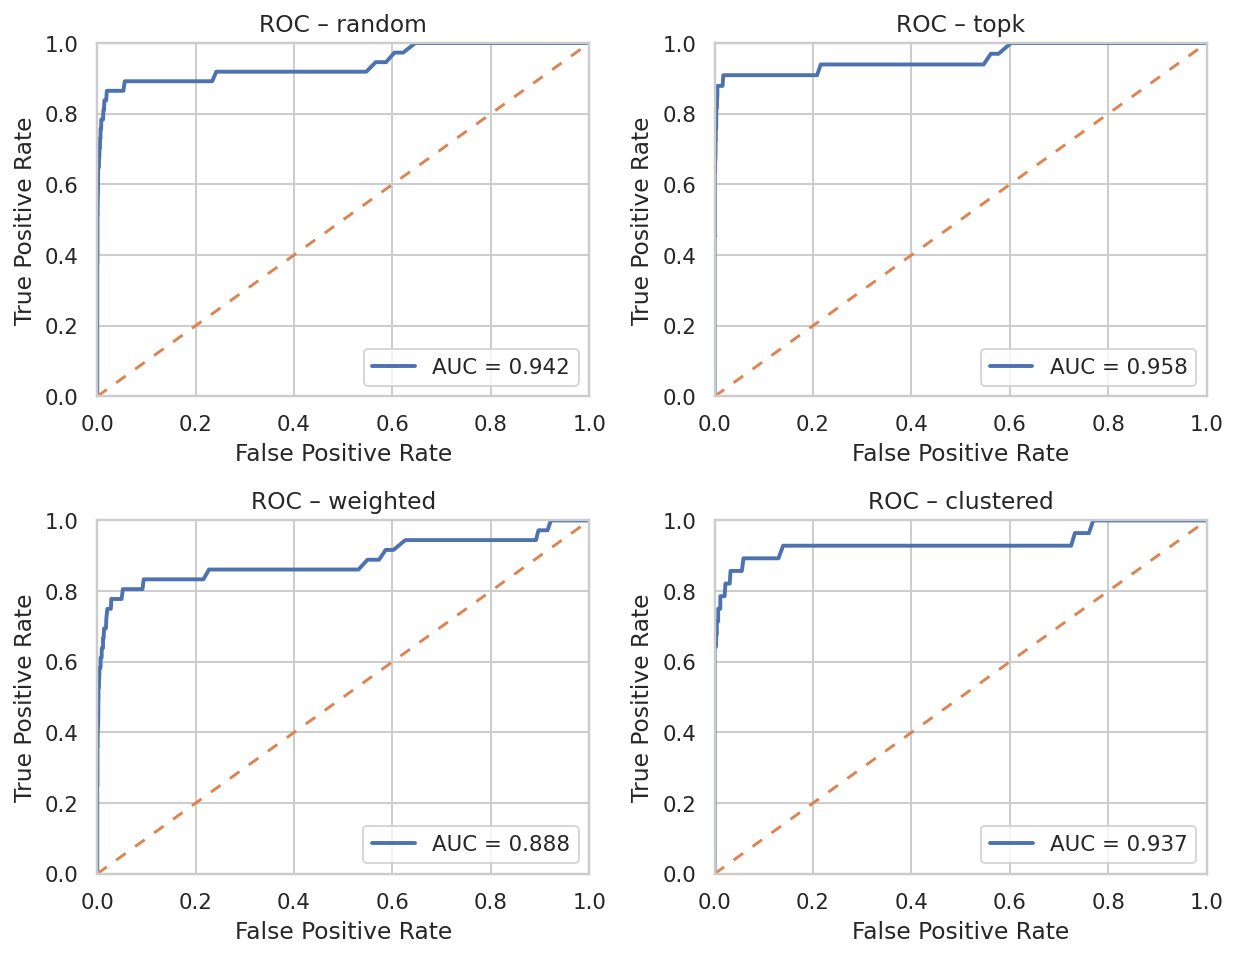

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

methods = ['random', 'topk', 'weighted', 'clustered']

# Collect ROC data for each selection
roc_data = {}  # method -> (fpr, tpr, auc)
for method in methods:
    idx_list = eval(f"indices_{method}")  # e.g., indices_random, indices_topk, ...
    all_X = np.vstack([client_test_data[i] for i in idx_list])
    all_y = np.hstack([client_test_labels[i] for i in idx_list])

    # Get probabilities from your (binary) classifier
    y_proba = global_model_random.predict_proba(all_X)[:, 1]
    auc = roc_auc_score(all_y, y_proba)
    fpr, tpr, _ = roc_curve(all_y, y_proba)
    roc_data[method] = (fpr, tpr, auc)

# ---- Plot (2x2) like your figure ----
fig, axes = plt.subplots(2, 2, figsize=(9, 7), dpi=140)
axes = axes.ravel()

for ax, method in zip(axes, methods):
    fpr, tpr, auc = roc_data[method]
    ax.plot(fpr, tpr, lw=2)
    ax.plot([0, 1], [0, 1], linestyle='--', dashes=(4, 4))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC – {method}")
    # A small legend box with AUC value
    ax.legend([f"AUC = {auc:.3f}"], loc="lower right", frameon=True)

plt.tight_layout()
plt.savefig("roc_auc_comparison.png", bbox_inches="tight")
plt.show()
